<a href="https://colab.research.google.com/github/tony-pitchblack/finrl-dt/blob/custom-backtesting/finrl_dt_replicate_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [97]:
# %load_ext autoreload
# %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
%%capture
!pip install git+https://github.com/tony-pitchblack/FinRL.git@benchmarking --no-deps \
    # --force-reinstall

In [2]:
%%capture
# Install the dependencies listed in the requirements.txt file
!wget https://raw.githubusercontent.com/tony-pitchblack/FinRL/benchmarking/requirements.txt -O requirements.txt
!pip install -r requirements.txt

In [3]:
# %%capture
# !pip install ray[rllib]

# Installs (old)

In [ ]:
# %%capture
# !pip install -q yfinance==0.2.50
# !pip install stable-baselines3
# !pip install finrl
# !pip install alpaca_trade_api
# !pip install exchange_calendars
# !pip install stockstats
# !pip install wrds

In [ ]:
# %%capture
# import numpy as np

# if np.__version__ != '1.26.4':
#     !pip install -q numpy==1.26.4 --force-reinstall

# import pandas as pd

# if pd.__version__ != '2.2.2':
#     !pip install -q pandas==2.2.2 --force-reinstall

In [ ]:
# %%capture
# !pip install ray[rllib]

# Imports

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import pandas as pd

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
os.environ["WANDB_API_KEY"] = "aee284a72205e2d6787bd3ce266c5b9aefefa42c"

PROJECT = 'finrl-dt-replicate'
ENTITY = "overfit1010"

# General funcs

In [5]:
#@title YahooDownloader (compatible with original FinRL)

from __future__ import annotations

import pandas as pd
import yfinance as yf


class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API

    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic, start=self.start_date, end=self.end_date, proxy=proxy
            )
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                # data_df = data_df.append(temp_df)
                data_df = pd.concat([data_df, temp_df], axis=0)
            else:
                num_failures += 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()

        try:
            # Convert wide to long format
            # print(f"DATA COLS: {data_df.columns}")
            data_df = data_df.sort_index(axis=1).set_index(['Date']).drop(columns=['tic']).stack(level='Ticker', future_stack=True)
            data_df.reset_index(inplace=True)
            data_df.columns.name = ''

            # convert the column names to standardized names
            data_df.rename(columns={'Ticker': 'Tic', 'Adj Close': 'Adjcp'}, inplace=True)
            data_df.rename(columns={col: col.lower() for col in data_df.columns}, inplace=True)

            columns = [
                "date",
                "tic",
                "open",
                "high",
                "low",
                "close",
                # "adjcp",
                "volume",
            ]

            data_df = data_df[columns]
            if 'adjcp' in data_df.columns:
                # use adjusted close price instead of close price
                data_df["close"] = data_df["adjcp"]
                # drop the adjusted close price column
                data_df = data_df.drop(labels="adjcp", axis=1)

        except NotImplementedError:
            print("the features are not supported currently")

        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df

In [6]:
#@title fix_daily_index

def make_daily_index(data_df, date_column='date', new_index_name='date_index'):
    # Get unique dates and create a mapping to daily indices
    total_dates = data_df[date_column].unique()
    date_to_index = {date: idx for idx, date in enumerate(sorted(total_dates))}
    return data_df[date_column].map(date_to_index)

def set_daily_index(data_df, date_column='date', new_index_name='date_index'):
    """
    Constructs a daily index from unique dates in the specified column.

    Parameters:
        data_df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the column containing dates.
        new_index_name (str): The name for the new index.

    Returns:
        pd.DataFrame: DataFrame with a daily index.
    """

    # Map dates to daily indices and set as index
    data_df[new_index_name] = make_daily_index(data_df, date_column='date', new_index_name='date_index')

    data_df.set_index(new_index_name, inplace=True)
    data_df.index.name = ''  # Remove the index name for simplicity

    return data_df

def fix_daily_index(df):
    if df.index.name == 'date':
        df.reset_index(inplace=True)

    daily_index = make_daily_index(df, date_column='date', new_index_name='date_index')
    if (df.index.values != daily_index.values).any():

        df.index = daily_index
        df.index.name = ''

    return df

# trade = fix_daily_index(trade)
# trade.index

In [7]:
#@title get dataset name

get_quarter = lambda date: f'Q{(date.month - 1) // 3 + 1}'

def get_quarterly_dataset_name(prefix, train_start_date, val_start_date, test_start_date):
    val_quarter = get_quarter(val_start_date)
    test_quarter = get_quarter(test_start_date)

    # Extract year and month
    train_start = f"{train_start_date.year}-{train_start_date.month:02}"
    val_start = f"{val_start_date.year}"
    test_start = f"{test_start_date.year}"

    # Construct the dataset name
    dataset_name = f"{prefix} | {train_start} | {val_start} {val_quarter} | {test_start} {test_quarter}"

    return dataset_name

def get_yearly_dataset_name(prefix, train_start, test_start, test_end):
    # Extract year and month
    train_start_str = f"{train_start.year}-{train_start.month:02}"
    test_start_str = f"{test_start.year}-{test_start.month:02}"
    test_end_str = f"{test_end.year}-{test_end.month:02}"

    # Construct the dataset name
    dataset_name = f"{prefix} | {train_start_str} | {test_start_str} | {test_end_str}"
    return dataset_name


In [8]:
#@title add_dataset

def add_dataset(stock_index_name, train_df, test_df):
    if 'datasets' not in globals():
        global datasets
        datasets = {}

    # Ensure datetime format
    if 'date' in train_df.columns:
        train_df.set_index('date', inplace=True)
    train_df.index = pd.to_datetime(train_df.index)

    if 'date' in test_df.columns:
        test_df.set_index('date', inplace=True)
    test_df.index = pd.to_datetime(test_df.index)

    train_start_date = train_df.index[0]
    test_start_date = test_df.index[0]
    test_end_date = test_df.index[-1]

    dataset_name = get_yearly_dataset_name(
        stock_index_name,
        train_start_date, test_start_date, test_end_date
    )

    train_df.reset_index(inplace=True)
    test_df.reset_index(inplace=True)

    train_df = set_daily_index(train_df)
    test_df = set_daily_index(test_df)

    ticker_list = train_df.tic.unique().tolist()

    datasets[dataset_name] = {
        'train': train_df,
        'test': test_df,
        'metadata': dict(
            stock_index_name = stock_index_name,
            train_start_date = train_start_date,
            test_start_date = test_start_date,
            test_end_date = test_end_date,
            num_tickers = len(ticker_list),
            ticker_list = ticker_list,
        )
    }

# Load data

## DATA: DOW-30 (rolling yearly windows)

In [9]:
#@title download full data
%%capture

min_test_start_year = 2020
max_test_start_year = 2025

train_years_count = 10
test_years_count = 1.5

min_date = \
    pd.Timestamp(year=min_test_start_year, month=1, day=1) - \
    pd.Timedelta(days=int(train_years_count * 365.2425))

max_date = \
    pd.Timestamp(year=max_test_start_year, month=1, day=1) + \
    pd.Timedelta(days=int(test_years_count * 365.2425))

# data_df = YahooDownloader(
#     start_date=min_date,
#     end_date=max_date,
#     ticker_list=config_tickers.DOW_30_TICKER
# ).fetch_data()

# data_df['date'] = pd.to_datetime(data_df['date'])

# # clip max year w.r.t. to available data
# max_data_date = data_df['date'].max()
# max_test_start_year = min(max_test_start_year, max_data_date.year)

In [10]:
#@title add features

# from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# fe = FeatureEngineer(use_turbulence=True, use_vix=True)
# preprocessed_data_df = fe.preprocess_data(data_df.astype({'date': str}))
# preprocessed_data_df.head()

In [11]:
#@title get_train_test_split
def get_train_test_split(data_df, train_years_count, test_years_count, test_start_year):
    test_start_date = pd.Timestamp(year=test_start_year, month=1, day=1)

    train_start_date = \
        test_start_date - \
        pd.Timedelta(days=int(train_years_count * 365.2425))

    test_end_date = \
        test_start_date + \
        pd.Timedelta(days=int(test_years_count * 365.2425))

    # Filter using the 'date' column
    train_df = data_df[(data_df['date'] >= train_start_date) & (data_df['date'] < test_start_date)]
    test_df = data_df[(data_df['date'] >= test_start_date) & (data_df['date'] < test_end_date)]

    return train_df, test_df

In [12]:
# preprocessed_data_df['date'] = pd.to_datetime(preprocessed_data_df['date'])

# for test_start_year in range(min_test_start_year, max_test_start_year + 1):
#     train_df, test_df = get_train_test_split(
#         # data_df,
#         preprocessed_data_df,

#         train_years_count, test_years_count, test_start_year
#     )

#     add_dataset('DOW_30', train_df, test_df)

#     print(f"Train start: {train_df['date'].min()}, Train end: {train_df['date'].max()}")
#     print(f"Test start: {test_df['date'].min()}, Test end: {test_df['date'].max()}")
#     print()

#     # break

# print(*list(datasets.keys()), sep='\n')

## DATA: DOW-30 (quarterly train/val/test)

In [13]:
train_start_date = '2015-01-01'
min_test_start_date = '2016-01-01'
max_test_end_date = '2016-10-01'

# train_start_date = '2009-01-01'
# min_test_start_date = '2016-01-01'
# max_test_end_date = '2020-08-01'

In [14]:
%%capture
#@title download

# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

# ########################

# data_df = YahooDownloader(
#     start_date= pd.Timestamp(train_start_date),
#     end_date= pd.Timestamp(max_test_end_date),
#     ticker_list=config_tickers.DOW_30_TICKER
# ).fetch_data()

# data_df['date'] = pd.to_datetime(data_df['date'])

In [15]:
#@title add features

# from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# fe = FeatureEngineer(use_turbulence=True, use_vix=True)
# preproc_df = fe.preprocess_data(data_df.astype({'date': str}))
# preproc_df['date'] = pd.to_datetime(preproc_df['date'])
# # preproc_df.head()

In [16]:
#@title generate_quarterly_date_ranges (old)
from calendar import monthrange

def generate_quarterly_date_ranges(train_start_date, min_test_start_date, max_test_end_date, preproc_df, return_strings=False):
    is_quarter_start = lambda date: date.month in [1, 4, 7, 10] and date.day == 1

    min_test_start_date = pd.Timestamp(min_test_start_date)
    train_start_date = pd.Timestamp(train_start_date)
    max_test_end_date = pd.Timestamp(max_test_end_date)

    assert is_quarter_start(train_start_date), f"train_start_date {train_start_date} is not a quarter start date."
    assert is_quarter_start(min_test_start_date), f"min_test_start_date {min_test_start_date} is not a quarter start date."

    assert max_test_end_date + pd.DateOffset(month=3) <= preproc_df['date'].max()
    assert train_start_date + pd.DateOffset(days=1) >= preproc_df['date'].min()

    test_start_date = min_test_start_date
    date_ranges = []
    while True:
        val_start_date = test_start_date - pd.DateOffset(months=3)
        test_end_date = test_start_date + pd.DateOffset(months=3)

        if test_end_date > max_test_end_date:
            break

        date_range = (dict(
            train_start_date = train_start_date,
            val_start_date = val_start_date,
            test_start_date = test_start_date,
            test_end_date = test_end_date,
        ))

        if return_strings:
            date_range = {k: str(v) for k, v in date_range.items()}

        date_ranges.append(date_range)

        test_start_date = test_end_date


    return date_ranges

# date_ranges = generate_quarterly_date_ranges(train_start_date, min_test_start_date, max_test_end_date, preproc_df)
# print(*date_ranges[:2], sep='\n')

In [17]:
#@title generate_quarterly_date_ranges

def generate_quarterly_date_ranges(
    train_start_date,
    min_test_start_date,
    max_test_end_date,
    return_strings=False,
    finetune_previous_val=False
):
    is_quarter_start = lambda date: date.month in [1, 4, 7, 10] and date.day == 1

    min_test_start_date = pd.Timestamp(min_test_start_date)
    train_start_date = pd.Timestamp(train_start_date)
    max_test_end_date = pd.Timestamp(max_test_end_date)

    assert is_quarter_start(train_start_date), f"train_start_date {train_start_date} is not a quarter start date."
    assert is_quarter_start(min_test_start_date), f"min_test_start_date {min_test_start_date} is not a quarter start date."

    test_start_date = min_test_start_date
    date_ranges = []
    full_train_start_date = train_start_date

    while True:
        val_start_date = test_start_date - pd.DateOffset(months=3)
        test_end_date = test_start_date + pd.DateOffset(months=3)

        if test_end_date > max_test_end_date:
            break

        if len(date_ranges) == 0:
            # The first date_range contains the full training period
            train_start_date = full_train_start_date
        elif finetune_previous_val:
            # Use the previous validation range as the training range
            train_start_date = date_ranges[-1]['val_start_date']

        date_range = dict(
            train_start_date=train_start_date,
            val_start_date=val_start_date,
            test_start_date=test_start_date,
            test_end_date=test_end_date,
        )

        if return_strings:
            date_range = {k: str(v) for k, v in date_range.items()}

        date_ranges.append(date_range)

        test_start_date = test_end_date

    return date_ranges

date_ranges = generate_quarterly_date_ranges(
    train_start_date,
    min_test_start_date,
    max_test_end_date,
    finetune_previous_val=True
)

print(*date_ranges, sep='\n')

{'train_start_date': Timestamp('2015-01-01 00:00:00'), 'val_start_date': Timestamp('2015-10-01 00:00:00'), 'test_start_date': Timestamp('2016-01-01 00:00:00'), 'test_end_date': Timestamp('2016-04-01 00:00:00')}
{'train_start_date': Timestamp('2015-10-01 00:00:00'), 'val_start_date': Timestamp('2016-01-01 00:00:00'), 'test_start_date': Timestamp('2016-04-01 00:00:00'), 'test_end_date': Timestamp('2016-07-01 00:00:00')}
{'train_start_date': Timestamp('2016-01-01 00:00:00'), 'val_start_date': Timestamp('2016-04-01 00:00:00'), 'test_start_date': Timestamp('2016-07-01 00:00:00'), 'test_end_date': Timestamp('2016-10-01 00:00:00')}


In [18]:
#@title split_data

def split_data(data_df, date_range):
    def subset_date_range(df, start_date, end_date):
        df = df[(df['date'] >= start_date) & (df['date'] < end_date)]
        df = fix_daily_index(df)
        return df

    return {
        'train': subset_date_range(data_df, date_range['train_start_date'], date_range['val_start_date']),
        'val': subset_date_range(data_df, date_range['val_start_date'], date_range['test_start_date']),
        'test': subset_date_range(data_df, date_range['test_start_date'], date_range['test_end_date']),
    }

# data_splits = split_data(preproc_df, date_ranges[0])
# data_splits['train'].head()

# Wandb funcs

In [19]:
#@title update_artifact

def update_artifact(folder_path, name_prefix, type):
    """
    Create or update a W&B artifact consisting of a folder.

    Args:
        run: The current W&B run.
        folder_path (str): Path to the folder to upload.
        artifact_name (str): Name of the artifact.
        artifact_type (str): Type of the artifact.
    """
    run = wandb.run
    artifact_name = f'{name_prefix}-{wandb.run.id}'

    # Create a new artifact
    artifact = wandb.Artifact(name=artifact_name, type=type)

    # Add the folder to the artifact
    artifact.add_dir(folder_path)

    # Log the artifact to W&B
    run.log_artifact(artifact)
    print(f"Artifact '{artifact_name}' has been updated and uploaded.")

In [20]:
#@title update_model_artifacts

def update_model_artifacts(log_results_folder=True):
    if log_results_folder:
        update_artifact(
            folder_path = RESULTS_DIR,
            name_prefix = 'results',
            type = 'results'
        )

    update_artifact(
        folder_path = TRAINED_MODEL_DIR,
        name_prefix = 'trained_models',
        type = 'trained_models'
    )

# Train SB3 models

## Init config & dataset

In [ ]:
period_idx = -1
train, val, test = quarterly_dataset[period_idx]

In [ ]:
config = {}

In [ ]:
#@title Config: dataset

# config.update(dict(
#     # dataset_name =  'DOW_30 | 2009-01 | 2020-07 | 2021-10',
#     dataset_name =  'DOW-30 (FinRL 2021) | 2009-01 | 2020-07 | 2021-10',
# ))

# dataset = datasets[config['dataset_name']]
# config.update(dataset['metadata'])
# train = dataset['train']

In [ ]:
#@title Get reference price interval

# %%capture

# REFERENCE_PRICE_END_DATE = '2024-12-21'
# REFERNCE_PRICE_WINDOW_DAYS = 30

# ref_price_start_date = pd.Timestamp(REFERENCE_PRICE_END_DATE) - pd.Timedelta(days=REFERNCE_PRICE_WINDOW_DAYS)
# ref_price_df = YahooDownloader(
#         start_date=ref_price_start_date,
#         end_date=REFERENCE_PRICE_END_DATE,
#         ticker_list=train.tic.unique().tolist(),
#         # ticker_list=config_tickers.DOW_30_TICKER
#     ).fetch_data()

In [ ]:
#@title Calculate fee percent based on average price for past N days

def cost_pct_from_avg_price(df, cost_abs, price_avg_days, verbose=False):
    df['date'] = pd.to_datetime(df['date'])
    avg_price_dict = {}
    for tic, _df in df.groupby('tic'):
        last_date = _df['date'].max()
        _df = _df[_df.date >= last_date - pd.Timedelta(days=price_avg_days)]
        avg_price = ((_df.high + _df.low) / 2).mean()
        avg_price_dict.update({tic: avg_price})

    avg_price_df = pd.DataFrame(avg_price_dict, index=[f'cost_avg']).T
    cost_pct_df = (cost_abs / avg_price_df).rename(columns={'cost_avg': 'cost_pct'})

    if verbose:
        display(avg_price_df.head())
        print()
        display(cost_pct_df.head())

    return cost_pct_df.values.flatten().tolist()

In [ ]:
# COST_ABS = 2.5
# COST_PCT = cost_pct_from_avg_price(
#     df=ref_price_df,
#     cost_abs=COST_ABS,
#     price_avg_days=REFERNCE_PRICE_WINDOW_DAYS,
#     verbose=True
# )

In [ ]:
# config.update({
#     'env_params': {
#         'initial_amount': 50000,

#         # 'cost_abs': COST_ABS,
#         # 'cost_pct': COST_PCT

#         'cost_abs': None,
#         'cost_pct': 0.001
#     }
# })


config.update({
    'initial_amount': 50000,

    # 'cost_abs': COST_ABS,
    # 'cost_pct': COST_PCT

    'cost_abs': None,
    'cost_pct': 0.001
})

config.keys()

In [ ]:
#@title Init env
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

cost_pct = config['cost_pct']
if isinstance(cost_pct, list):
    assert len(cost_pct) == stock_dimension
    buy_cost_pct = sell_cost_pct = cost_pct
elif isinstance(cost_pct, (int, float)):
    buy_cost_pct = sell_cost_pct = [ config['cost_pct'] ] * stock_dimension
else:
    raise ValueError

num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": config['initial_amount'],
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_pct,
    "sell_cost_pct": sell_cost_pct,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,

    "print_verbosity": 1,
    "make_plots": True
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Init wandb

In [ ]:
# !rm -rf ./*

In [ ]:
#@title init run
import wandb
import random
import string

def generate_run_name(prefix, n=5):
    random_str = ''.join(random.choices(string.ascii_letters + string.digits, k=n))
    return f"{prefix} | {random_str}"


wandb.finish()
wandb.init(
    project=PROJECT,
    name=generate_run_name(config['dataset_name'])
)

wandb.config.update(config)

In [ ]:
#@title update_artifact

def update_artifact(folder_path, name_prefix, type):
    """
    Create or update a W&B artifact consisting of a folder.

    Args:
        run: The current W&B run.
        folder_path (str): Path to the folder to upload.
        artifact_name (str): Name of the artifact.
        artifact_type (str): Type of the artifact.
    """
    run = wandb.run
    artifact_name = f'{name_prefix}-{wandb.run.id}'

    # Create a new artifact
    artifact = wandb.Artifact(name=artifact_name, type=type)

    # Add the folder to the artifact
    artifact.add_dir(folder_path)

    # Log the artifact to W&B
    run.log_artifact(artifact)
    print(f"Artifact '{artifact_name}' has been updated and uploaded.")

In [ ]:
#@title update_model_artifacts

def update_model_artifacts():
    update_artifact(
        folder_path = RESULTS_DIR,
        name_prefix = 'results',
        type = 'results'
    )

    update_artifact(
        folder_path = TRAINED_MODEL_DIR,
        name_prefix = 'trained_models',
        type = 'trained_models'
    )

In [ ]:
#@title update_dataset_artifact

from pathlib import Path

DATASET_DIR = Path('./dataset')
os.makedirs(DATASET_DIR, exist_ok=True)

dataset = datasets[config['dataset_name']]
dataset['train'].to_csv(DATASET_DIR / 'train_data.csv')
dataset['test'].to_csv(DATASET_DIR / 'test_data.csv')

update_artifact(
    folder_path = DATASET_DIR,
    name_prefix = 'dataset',
    type = 'dataset'
)

## Train FinRL models

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./results/

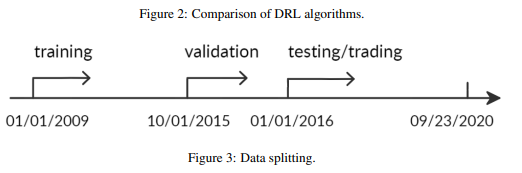

In [ ]:
#@title Define metric functions

def calculate_mdd(asset_values):
    """
    Calculate the Maximum Drawdown (MDD) of a portfolio.
    """
    running_max = asset_values.cummax()
    drawdown = (asset_values - running_max) / running_max
    mdd = drawdown.min() * 100  # Convert to percentage
    return mdd

def calculate_sharpe_ratio(asset_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a portfolio.
    """
    # Calculate daily returns
    returns = asset_values.pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  # Assuming 252 trading days

    if excess_returns.std() == 0:
        return 0.0
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized
    return sharpe_ratio

def calculate_annualized_return(asset_values):
    """
    Calculate the annualized return of a portfolio.
    """
    # Assume `asset_values` is indexed by date or trading day
    total_return = (asset_values.iloc[-1] / asset_values.iloc[0] - 1) * 100
    num_days = (asset_values.index[-1] - asset_values.index[0]).days
    annualized_return = (1 + total_return) ** (365 / num_days) - 1
    return annualized_return

In [ ]:
#@title compute metrics
import wandb
from typing import List
import numpy as np

def compute_metrics(account_values: List[pd.DataFrame, pd.Series, np.array], use_round=True):
    """
    If DataFrame then should contain two columns - 'date' and name of algo, e.g. 'a2c'.
    """

    if isinstance(account_values, pd.DataFrame):
        assert isinstance(account_values, pd.DataFrame)
        if 'date' not in account_values.columns:
            if account_values.index.name == 'date':
                account_values.reset_index(inplace=True)
            else:
                raise ValueError("should contain 'date' column or index")
        account_values = account_values.dropna().set_index('date').iloc[:, 0]
    elif isinstance(account_values, np.ndarray):
        account_values = pd.Series(account_values)

    sharpe = calculate_sharpe_ratio(account_values)
    mdd = calculate_mdd(account_values)
    cum_ret = (account_values.iloc[-1] - account_values.iloc[0]) / account_values.iloc[0] * 100
    # num_days = (account_values.index.max() - account_values.index.min()).days
    num_days = len(account_values)
    ann_ret = ((1 + cum_ret / 100) ** (365 / num_days) - 1) * 100

    metrics = {
            f'sharpe_ratio': sharpe,
            f'mdd': mdd,
            f'ann_return': ann_ret,
            f'cum_return': cum_ret,
        }

    if use_round:
        metrics = {k: round(v, 2) for k, v in metrics.items()}

    return metrics

def get_env_metrics(env):
    end_total_asset = env.state[0] + sum(
        np.array(env.state[1 : (env.stock_dim + 1)])
        * np.array(env.state[(env.stock_dim + 1) : (env.stock_dim * 2 + 1)])
    )

    return {
        'begin_total_asset': env.asset_memory[0],
        'end_total_asset': end_total_asset,
        'total_cost': env.cost,
        'total_trades': env.trades,
    }

In [ ]:
#@title log_metrics

def log_metrics_to_wandb(metrics, model_name, split_label, step=None):
    assert model_name in ['a2c', 'ddpg', 'sac', 'ppo', 'td3', 'best_model', 'chosen_model']

    rename_metrics = lambda model_name: {
        f"{key}/{model_name}": value for key, value in metrics.items()
    }

    renamed_metrics = rename_metrics(model_name)
    wandb.log({split_label: renamed_metrics}, step=step)
    # wandb.run.save()

In [ ]:
#@title WandbLoggerCallback
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import pandas as pd
import numpy as np

class MetricLoggerCallback(BaseCallback):
    def __init__(self, model_name, split_label, verbose=0):
        super(MetricLoggerCallback, self).__init__(verbose)

        self.split_label = split_label
        self.model_name = model_name

    def _on_step(self) -> bool:
        env = self.training_env.envs[0]

        # Unwrap from Monitor if needed
        while isinstance(env, Monitor):
            env = env.env

        # Check if the episode is terminal
        env.terminal = env.day >= len(env.df.index.unique()) - 1
        if env.terminal:
            df_account_value = pd.DataFrame({
                self.model_name: env.asset_memory,
                'date': env.date_memory
            })

            # Compute metrics
            metrics = compute_metrics(df_account_value)
            # env_metrics = get_env_metrics(env)
            # metrics.update(env_metrics)

            # Log current model metrics
            log_metrics_to_wandb(metrics, self.model_name, self.split_label)

        return True

In [ ]:
#@title Custom DRLAgent (w/ wandb callback)
from finrl.agents.stablebaselines3.models import DRLAgent, TensorboardCallback
from stable_baselines3.common.callbacks import CallbackList
import wandb

class DRLAgent(DRLAgent):
    @staticmethod
    def train_model(
        model,
        tb_log_name,
        total_timesteps=5000,
        custom_callbacks=[],
        log_to_wandb=False
    ):
        # Ensure TensorboardCallback is always included
        tensorboard_callback = TensorboardCallback()

        # Initialize default callbacks
        metric_logger_callback = MetricLoggerCallback(
            model_name=tb_log_name,
            split_label='train',
            verbose=1,
            log_to_wandb=log_to_wandb
        )

        # Combine all callbacks (always include Tensorboard, SharpeRatio, and MaxSharpeRatio by default)
        callbacks_to_use = [
            tensorboard_callback,
            metric_logger_callback,
        ]

        if custom_callbacks:
            callbacks_to_use.extend(custom_callbacks)

        # Wrap all callbacks into a CallbackList
        combined_callback = CallbackList(callbacks_to_use)

        # Train the model with the combined callbacks
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=combined_callback,
        )
        return model

In [ ]:
#@title train models

check_and_make_directories([TRAINED_MODEL_DIR])

env_train, _ = e_train_gym.get_sb_env()

# Set the corresponding values to 'True' for the algorithms that you want to use

# if_using_a2c = True
if_using_a2c = False

# if_using_ddpg = True
if_using_ddpg = False

# if_using_ppo = True
if_using_ppo = False

# if_using_td3 = True
if_using_td3 = False

# if_using_sac = True
if_using_sac = False

if if_using_a2c:
    print("training A2C agent")
    agent = DRLAgent(env = env_train)
    model_a2c = agent.get_model("a2c")

    # set up logger
    tmp_path = RESULTS_DIR + '/a2c'
    !rm -rf {tmp_path}/*
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_a2c.set_logger(new_logger_a2c)

    trained_a2c = agent.train_model(model=model_a2c,
                                    tb_log_name='a2c',
                                    # total_timesteps=50_000,
                                    total_timesteps=3500,
                                    ) if if_using_a2c else None

    trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
    update_model_artifacts()

if if_using_ddpg:
    print("training DDPG agent")
    agent = DRLAgent(env = env_train)
    model_ddpg = agent.get_model("ddpg")

    # set up logger
    tmp_path = RESULTS_DIR + '/ddpg'
    !rm -rf {tmp_path}/*
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ddpg.set_logger(new_logger_ddpg)

    trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                            #  total_timesteps=50_000,
                             total_timesteps=3500
                            ) if if_using_ddpg else None

    trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
    update_model_artifacts()

if if_using_td3:
    print("training TD3 agent")
    agent = DRLAgent(env = env_train)
    TD3_PARAMS = {"batch_size": 100,
                "buffer_size": 1000000,
                "learning_rate": 0.001}

    model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

    # set up logger
    tmp_path = RESULTS_DIR + '/td3'
    !rm -rf {tmp_path}/*
    new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_td3.set_logger(new_logger_td3)

    trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

    trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
    update_model_artifacts()

if if_using_sac:
    print("training SAC agent")
    agent = DRLAgent(env = env_train)
    SAC_PARAMS = {
        "batch_size": 128,
        "buffer_size": 100000,
        "learning_rate": 0.0001,
        "learning_starts": 100,
        "ent_coef": "auto_0.1",
    }

    model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

    # set up logger
    tmp_path = RESULTS_DIR + '/sac'
    !rm -rf {tmp_path}/*
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_sac.set_logger(new_logger_sac)

    trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None
    trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None
    update_model_artifacts()

if if_using_ppo:
    agent = DRLAgent(env = env_train)
    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.00025,
        "batch_size": 128,
    }
    algo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
    # set up logger
    tmp_path = RESULTS_DIR + '/ppo'
    !rm -rf {tmp_path}/*
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    algo.set_logger(new_logger_ppo)

    trained_ppo = agent.train_model(model=algo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

    trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
    update_model_artifacts()

In [ ]:
# wandb.finish()

# Train SB3 vs RLLib models (np env)

## Init np env

In [21]:
run_config = {
    'cost_pct': 0.001,
    'initial_amount': 50_000,
    'turbulence_threshold': 99,
    'if_vix': True
}

In [22]:
#@title Init data
# date_range = date_ranges[1]

# #####################

# data_splits = split_data(preproc_df, date_range)
# train = data_splits['train']
# val = data_splits['val']
# print(train['date'].max() - train['date'].min())
# val.head()

In [23]:
#@title Init StockTradingEnv (custom vectorization)

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from copy import deepcopy

class StockTradingEnv(StockTradingEnv):
    def __init__(self, *args, if_async=False, n_envs=1, **kwargs, ):
        super().__init__(*args, **kwargs)
        self.n_envs = n_envs
        if if_async:
            self.vec_env_cls = SubprocVecEnv
            self.vec_env_kwargs = dict(start_method='fork')
        else:
            self.vec_env_cls = DummyVecEnv
            self.vec_env_kwargs = {}

    def get_sb_env(self):
        e = self.vec_env_cls([deepcopy(self) for _ in range(self.n_envs)], **self.vec_env_kwargs)
        # e = make_vec_env(deepcopy(self), n_envs=self.n_envs, vec_env_cls=self.vec_env_cls)
        obs = e.reset()
        return e, obs

def init_env(df, run_config, mode="", previous_state=None,
             if_async=False, n_envs=1):
    assert mode in ['train', 'val', 'test', ""]
    if mode:
        print(f"Initializing '{mode}' env.")

    stock_dimension = len(df.tic.unique())
    state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

    cost_pct = run_config['cost_pct']
    if isinstance(cost_pct, list):
        assert len(cost_pct) == stock_dimension
        buy_cost_pct = sell_cost_pct = cost_pct
    elif isinstance(cost_pct, (int, float)):
        buy_cost_pct = sell_cost_pct = [ run_config['cost_pct'] ] * stock_dimension
    else:
        raise ValueError

    num_stock_shares = [0] * stock_dimension

    print(f"Initializing env with initial amount: {previous_state[0] if previous_state is not None else run_config['initial_amount']}")
    env_kwargs = {
        "hmax": 100,
        "initial_amount": previous_state[0] if previous_state is not None else run_config['initial_amount'],
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_pct,
        "sell_cost_pct": sell_cost_pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "turbulence_threshold": run_config['turbulence_threshold'] if 'turbulence_threshold' in run_config else None,
        "print_verbosity": 1,
        "mode": mode,

        "initial": False if previous_state is not None else True,
        "previous_state": previous_state if previous_state is not None else [],
    }

    env_kwargs.update({
        'if_async': if_async,
        'n_envs': n_envs
    })

    e_train_gym = StockTradingEnv(df = df, **env_kwargs)
    # e_train_gym = e_train_gym.get_sb_env()
    return e_train_gym

In [24]:
#@title load_cached_data
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.data_processor import DataProcessor
import hashlib

NY = "America/New_York"

CACHE_DIR = './cache'
os.makedirs(CACHE_DIR, exist_ok=True)

def stable_hash(data):
    return hashlib.sha256(str(data).encode()).hexdigest()

def load_cached_data(
    start_date,
    end_date,
    ticker_list=DOW_30_TICKER,
    technical_indicator_list=INDICATORS,
    time_interval='1d',
    if_vix=True,
    ignore_cache=False
):
    data_hash = stable_hash(tuple(sorted(ticker_list) + sorted(technical_indicator_list) + [if_vix]))
    file_path = Path(CACHE_DIR) / f"{start_date}_{end_date}_{time_interval}_{data_hash}.csv"

    dp = DataProcessor(
        data_source='yahoofinance',
        tech_indicator=technical_indicator_list,
        vix=if_vix,
    )

    if os.path.isfile(file_path) and not ignore_cache:
        print(f"Using cached data: {file_path}")
        data = pd.read_csv(file_path, index_col=0)
        data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True) \
            .dt.tz_convert(NY).dt.tz_localize(None)

        return data, dp
    else:
        print("Creating new data.")

    data = dp.download_data(ticker_list, start_date, end_date, time_interval)
    data = dp.clean_data(data)
    data = dp.add_technical_indicator(data, technical_indicator_list)

    if if_vix:
        data = dp.add_vix(data)
    else:
        data = dp.add_turbulence(data)


    data.to_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True) \
        .dt.tz_convert(NY).dt.tz_localize(None)
    return data, dp

date_range=date_ranges[0]
data, data_processor = load_cached_data(
    start_date=date_range['train_start_date'],
    end_date=date_range['test_end_date'],
    ignore_cache=False
)

Using cached data: cache/2015-01-01 00:00:00_2016-04-01 00:00:00_1d_e4ea6619c36bd5c7165dda736c285494aa3defe9ac6b9a4e0ed8216efc4875c7.csv


In [25]:
#@title get_env_config

def get_env_config(
    data: pd.DataFrame,
    data_processor: DataProcessor,
    start_date,
    end_date,
    if_train,
):
    """
    Uses data_processor to convert data to array.
    WARNING: data_processor should be same as the one that was used to create the data.
    """

    data = data[(data['timestamp'] >= start_date) & (data['timestamp'] < end_date)]

    (
        price_array,
        tech_array,
        turbulence_array,
        timestamp_array
    ) = data_processor.df_to_array(data, return_timestamps=True)

    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "timestamp_array": timestamp_array,
        "if_train": if_train
    }

    return env_config

train_np_env_config = get_env_config(
    data,
    data_processor,
    start_date=date_range['train_start_date'],
    end_date=date_range['val_start_date'],
    if_train=True,
)

val_np_env_config = get_env_config(
    data,
    data_processor,
    start_date=date_range['val_start_date'],
    end_date=date_range['test_start_date'],
    if_train=False
)

test_np_env_config = get_env_config(
    data,
    data_processor,
    start_date=date_range['test_start_date'],
    end_date=date_range['test_end_date'],
    if_train=False,
)

train_np_env_config.keys()

dict_keys(['price_array', 'tech_array', 'turbulence_array', 'timestamp_array', 'if_train'])

In [26]:
#@title Init StockTradingEnv (numpy)

from finrl.meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
from finrl.meta.data_processor import DataProcessor
from finrl.config_tickers import DOW_30_TICKER
from finrl.config import INDICATORS
# from finrl.config import CACHE_DIR

def init_env(
    np_env_config,

    # run_config,
    initial_amount,
    cost_pct,

    mode,
    turbulence_threshold=99,
    initial_stocks=None
):
    assert mode in ['train', 'val', 'test']

    print(f"Initializing {'train' if np_env_config['if_train'] else 'eval'} env...", end=' ')
    env = StockTradingEnv(
        config=np_env_config,
        initial_capital=initial_amount,
        buy_cost_pct=cost_pct,
        sell_cost_pct=cost_pct,
        turbulence_thresh=turbulence_threshold,
        initial_stocks=np.array(initial_stocks) if isinstance(initial_stocks, list) else initial_stocks
    )
    print('Done.')

    return env

def create_stock_trading_env(env_config):
    return init_env(**env_config)

# env = init_env(
#     val_np_env_config,
#     initial_amount=run_config['initial_amount'],
#     cost_pct=run_config['cost_pct'],
#     mode='train'
# )

## Metric funcs

In [27]:
#@title define metrics

def calculate_mdd(asset_values):
    """
    Calculate the Maximum Drawdown (MDD) of a portfolio.
    """
    running_max = asset_values.cummax()
    drawdown = (asset_values - running_max) / running_max
    mdd = drawdown.min() * 100  # Convert to percentage
    return mdd

def calculate_sharpe_ratio(asset_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a portfolio.
    """
    # Calculate daily returns
    returns = asset_values.pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  # Assuming 252 trading days

    if excess_returns.std() == 0:
        return 0.0
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized
    return sharpe_ratio

def calculate_annualized_return(asset_values):
    """
    Calculate the annualized return of a portfolio.
    """
    # Assume `asset_values` is indexed by date or trading day
    total_return = (asset_values.iloc[-1] / asset_values.iloc[0] - 1) * 100
    num_days = (asset_values.index[-1] - asset_values.index[0]).days
    annualized_return = (1 + total_return) ** (365 / num_days) - 1
    return annualized_return

In [28]:
#@title compute metrics
import wandb
from typing import List, Union
import numpy as np


def compute_metrics(account_values: List[Union[pd.DataFrame, pd.Series, np.array]]):
    """
    If DataFrame then should contain two columns - 'date' and name of algo, e.g. 'a2c'.
    """

    if isinstance(account_values, pd.DataFrame):
        assert isinstance(account_values, pd.DataFrame)
        if 'date' not in account_values.columns:
            if account_values.index.name == 'date':
                account_values.reset_index(inplace=True)
            else:
                raise ValueError("should contain 'date' column or index")
        account_values = account_values.dropna().set_index('date').iloc[:, 0]
    elif isinstance(account_values, (np.ndarray, list)):
        account_values = pd.Series(account_values)

    sharpe = calculate_sharpe_ratio(account_values)
    mdd = calculate_mdd(account_values)
    cum_ret = (account_values.iloc[-1] - account_values.iloc[0]) / account_values.iloc[0] * 100
    # num_days = (account_values.index.max() - account_values.index.min()).days
    num_days = len(account_values)
    ann_ret = ((1 + cum_ret / 100) ** (365 / num_days) - 1) * 100

    return {
            f'sharpe_ratio': sharpe,
            f'mdd': mdd,
            f'ann_return': ann_ret,
            f'cum_return': cum_ret,
        }

def get_env_metrics(env):
    end_total_asset = env.state[0] + sum(
        np.array(env.state[1 : (env.stock_dim + 1)])
        * np.array(env.state[(env.stock_dim + 1) : (env.stock_dim * 2 + 1)])
    )

    return {
        'begin_total_asset': env.asset_memory[0],
        'end_total_asset': end_total_asset,
        'total_cost': env.cost,
        'total_trades': env.trades,
    }

In [29]:
#@title log_metrics_to_wandb

def log_metrics_to_wandb(
        metrics,
        model_name,
        split_label,
        step=None,
        metric_prefix=''
    ):

    print(f'log_metrics for {model_name}')
    assert model_name in ['a2c', 'ddpg', 'sac', 'ppo', 'td3', 'best_model', 'chosen_model']

    rename_metrics = lambda model_name: {
        f"{metric_prefix}{metric_name}/{model_name}": value for metric_name, value in metrics.items()
    }

    renamed_metrics = rename_metrics(model_name)
    wandb.log({split_label: renamed_metrics}, step=step)
    # wandb.run.save()

In [30]:
#@title benchmark_exec_time
import pandas as pd
from time import perf_counter
from functools import wraps

def benchmark_exec_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        start = perf_counter()
        output = func(*args, **kwargs)
        end = perf_counter()

        exec_time_sec = end - start

        data = {
            "func_name": func.__name__,
            "exec_time_sec": exec_time_sec,
        }
        print(f'\nBenchmark results: {data}')
        return output, exec_time_sec

    return wrapper

## Train SB3

In [31]:
#@title (SB3) MetricLoggerCallback (np env)
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import pandas as pd
import numpy as np

class MetricLoggerCallback(BaseCallback):
    def __init__(self, model_name, split_label, verbose=0, log_to_wandb=False):
        super(MetricLoggerCallback, self).__init__(verbose)

        self.split_label = split_label
        self.model_name = model_name
        self.log_to_wandb = log_to_wandb

    def _on_step(self) -> bool:
        if self.training_env is not None:
            env = self.training_env.envs[0]
        elif self.eval_env is not None:
            env = self.eval_env.envs[0]

        # Unwrap from Monitor if needed
        while isinstance(env, Monitor):
            env = env.env

        # Check if the episode is terminal
        env_terminal = env.day >= env.price_ary.shape[0] - 2
        if env_terminal:
            df_account_value = env.save_asset_memory()
            metrics = compute_metrics(df_account_value)

            # Log current model metrics
            if self.log_to_wandb:
                log_metrics_to_wandb(metrics, self.model_name, self.split_label)

        return True

In [32]:
#@title EvalMetricLoggerCallback (using evaluate_policy)

from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np

def metric_logger_callback(locals_, globals_):
    """
    Function-based callback for evaluate_policy() that logs metrics once
    an episode finishes. Supports both single and multi-environment setups.

    :param locals_: dict of local variables in evaluate_policy (contains 'env', 'done', etc.)
    :param globals_: dict of global variables in evaluate_policy
    :return: (bool) If the evaluation loop should continue (always True here)
    """
    env = locals_["env"]         # Vectorized or single environment
    n_envs = locals_["n_envs"]   # Number of parallel environments
    done = locals_["done"]       # Bool or array of bool if n_envs > 1

    # For single environment, done is just a bool
    # For multiple environments, done is an array of bool of length n_envs
    if n_envs == 1:
        # Unwrap any DummyVecEnv or Monitor wrappers
        base_env = env

        # Unwrap DummyVecEnv
        while hasattr(base_env, "envs"):
            base_env = base_env.envs[0]

        # print(f"Done env day: {base_env.day}")
        done = base_env.day >= base_env.price_ary.shape[0] - 2
        if done:
            # print(f"Env finished on day: {base_env.day}")

            # Now we have the real environment
            df_account_value = base_env.save_asset_memory()
            metrics = compute_metrics(df_account_value)
            print("[metric_logger_callback] Single-env metrics:", metrics)
    else:
        # Multi-env case
        # We may accumulate metrics for each env that just finished
        # and optionally average them after all are done
        finished_env_indices = np.where(done)[0]  # Indices of envs that are done
        if len(finished_env_indices) > 0:
            metrics_list = []
            for i in finished_env_indices:
                df_account_value = env.get_attr("save_asset_memory", indices=i)[0]
                metrics_i = compute_metrics(df_account_value)
                metrics_list.append(metrics_i)
                print(f"[metric_logger_callback] Env #{i} metrics: {metrics_i}")

            # Optionally average metrics across finished envs
            if len(metrics_list) > 1:
                # Ensure all metrics have the same keys
                avg_metrics = {}
                for key in metrics_list[0].keys():
                    avg_metrics[key] = np.mean([m[key] for m in metrics_list])
                print("[metric_logger_callback] Average metrics of finished envs:", avg_metrics)

    return True  # Return True to continue evaluation

class EvalMetricLoggerCallback(EvalCallback):
    def __init__(self, eval_env, model_name, split_label, log_to_wandb=False, **kwargs):
        """
        Custom EvalCallback that logs evaluation metrics using `evaluate_policy()`.
        """
        super().__init__(eval_env, **kwargs)
        self.split_label = split_label
        self.model_name = model_name
        self.log_to_wandb = log_to_wandb
        self.metric_logger = MetricLoggerCallback(model_name, split_label, log_to_wandb)

    def _on_step(self) -> bool:
        """
        Runs `evaluate_policy()` with `MetricLoggerCallback` and logs results after evaluation.
        """
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            # Evaluate using `evaluate_policy()`, passing `MetricLoggerCallback`
            evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=self.deterministic,
                render=self.render,
                warn=self.warn,
                # callback=self.metric_logger._on_step  # 🔹 Logs metrics after evaluation
                callback=metric_logger_callback
            )

        return super()._on_step()  # Run default EvalCallback logic

In [33]:
#@title SB3 train/val configs

# import torch
# from stable_baselines3.common.callbacks import EvalCallback

# model_name = 'ppo'
# log_to_wandb = False

# train_env_config = {
#     "initial_amount": run_config['initial_amount'],
#     "cost_pct": run_config['cost_pct'],
#     "mode": 'train',
#     'np_env_config': train_np_env_config
# }

# val_env_config = {
#     "initial_amount": run_config['initial_amount'],
#     "cost_pct": run_config['cost_pct'],
#     "mode": 'val',
#     'np_env_config': val_np_env_config
# }

# PPO_PARAMS = {
#     "n_steps": 2048, # rllib batch_size
#     "n_epochs": 10,
#     "batch_size": 128, # rllib minibatch_size

#     "ent_coef": 0.01,
#     "learning_rate": 0.00025,
#     "device": "cuda" if torch.cuda.is_available() else 'cpu'
# }

In [34]:
#@title Train SB3 model

@benchmark_exec_time
def _train_sb3(total_timesteps=200_000, custom_callbacks=[], log_to_wandb=False):
    trained_model = agent.train_model(
        model=algo,
        tb_log_name='ppo',
        total_timesteps=total_timesteps,
        custom_callbacks=custom_callbacks,
        log_to_wandb=log_to_wandb
    )

# if log_to_wandb:
#     wandb.finish()
#     wandb.init(ENTITY, PROJECT)

# train_env = init_env(**train_env_config)
# val_env = init_env(**val_env_config)

# eval_callback = EvalMetricLoggerCallback(
#     eval_env=val_env,
#     model_name="ppo",
#     split_label="val",
#     log_to_wandb=log_to_wandb,
#     eval_freq=250,  # Evaluate every 1k steps
#     deterministic=True,
#     render=False
# )

# # eval_callback = EvalCallback(
# #     eval_env=val_env,
# #     callback_after_eval=MetricLoggerCallback(
# #         model_name="ppo",
# #         split_label="val",
# #         log_to_wandb=log_to_wandb,
# #     ),
# #     eval_freq=1000,  # Evaluate every 1k steps
# #     deterministic=True,
# #     render=False
# # )

# agent = DRLAgent(env = train_env)
# algo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)
# new_logger_ppo = configure(RESULTS_DIR + '/ppo', ["stdout", "csv", "tensorboard"])
# algo.set_logger(new_logger_ppo)

# _train_sb3(
#     500,
#     custom_callbacks=[eval_callback],
#     log_to_wandb=log_to_wandb
# )

In [35]:
#@title FUNC: evaluate_model (sb3)

def evaluate_model(algo, model_name, mode, np_env_config, run_config, turbulence_thresh=None,
                   log_to_wandb=False):

    if turbulence_thresh is None:
        turbulence_thresh = run_config.get('turbulence_thresh', 99)

    turbulence_name = 'turbulence' if not run_config.get('if_vix', None) else '^VIX'
    print(f"Evaluating for `{mode}` using `{turbulence_name}`: {turbulence_thresh}")

    env_config = {
        # "df": val,
        "np_env_config": np_env_config,
        # "run_config": run_config,

        "initial_amount": run_config['initial_amount'],
        "cost_pct": run_config['cost_pct'],

        "mode": mode,
        'turbulence_threshold': turbulence_thresh
    }

    eval_env = create_stock_trading_env(env_config)

    # Reset the environment
    state, info = eval_env.reset()
    done = False

    while not done:
        # Predict action using the trained SB3 model
        action, _ = algo.predict(state, deterministic=True)

        # Clip action to ensure it's within valid bounds
        action = np.clip(action, eval_env.action_space.low, eval_env.action_space.high)

        # Perform the action in the environment
        state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated

    df_account_value = eval_env.save_asset_memory()
    metrics = compute_metrics(df_account_value)
    print(metrics)

    if log_to_wandb:
        turbulence_log_name = 'ti' if not run_config.get('if_vix', None) else 'vix'
        for metric_name, metric_value in metrics.items():
            metric_name = f"{mode}.{turbulence_log_name}_{turbulence_thresh}.{metric_name}/{model_name}"
            wandb.run.summary[metric_name] = metric_value

    turbulence_series = pd.Series(
        np_env_config['turbulence_array'][:len(df_account_value)],
        index=df_account_value['date'],
        name=turbulence_name
    )

    eval_result = {
        'account_value': df_account_value.rename(columns={'account_value': model_name}),
        'turbulence_series': turbulence_series,
        'turbulence_thresh': turbulence_thresh
    }

    return eval_result

In [36]:
#@title evaluate_model (sb3)

# train_result = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = train_np_env_config,
#     mode='train',
#     log_to_wandb=log_to_wandb
# )

# val_result = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = val_np_env_config,
#     mode='val',
#     log_to_wandb=log_to_wandb
# )

# test_result = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = test_np_env_config,
#     mode='test',
#     log_to_wandb=log_to_wandb
# )

In [37]:
# %timeit -n 1 -r 2 _train_sb3(int(50_000 / env_config['n_envs']))

## Train RLLib

In [38]:
import ray

ray.shutdown()
ray.init()

2025-02-20 16:05:50,213	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.11
Ray version:,2.42.1
Dashboard:,http://127.0.0.1:8265


In [39]:
#@title MetricsLoggerCallback (class)
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from typing import Optional, Sequence
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv

class MetricsLoggerCallback(DefaultCallbacks):
    def __init__(self, model_name, ema_coeff=0.2, ma_window=20, log_to_wandb=False):
        super().__init__()

        self.model_name = model_name
        self.ema_coeff = ema_coeff
        self.ma_window = ma_window
        self.metric_names = set()
        self.log_to_wandb = log_to_wandb

    def unwrap_env(self, env):
        env = env.unwrapped
        # print(type(env))
        # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.vector.sync_vector_env.SyncVectorEnv'>

        if isinstance(env, AsyncVectorEnv):
            return env
        else:
            env = env.envs[0]
            # print(type(env))
            # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.wrappers.common.OrderEnforcing'>

            env = env.env
            # print(type(env))
            # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.wrappers.common.PassiveEnvChecker'>

            env = env.env
            # print(type(env))
            # (SingleAgentEnvRunner pid=127688) <class 'finrl.meta.env_stock_trading.env_stocktrading.StockTradingEnv'>
        return env

    def on_episode_step(
            self,
            *,
            episode,
            env_runner,
            metrics_logger,
            env,
            env_index,
            rl_module,
            **kwargs,
        ) -> None:

        env = self.unwrap_env(env)

        if isinstance(env, AsyncVectorEnv):
            asset_values = env.get_attr('asset_memory')
            asset_values = pd.concat([pd.Series(av) for av in asset_values], axis=1).mean(axis=1)

            # TODO: save_asset_memory
            raise NotImplementedError
        else:
            # asset_values = env.asset_memory
            asset_values = env.save_asset_memory()

        # print(f"Env {env_index} day: {env.day}")
        metrics = compute_metrics(asset_values)

        # mode = env.mode
        for metric_name, metric_value in metrics.items():
            # metric_name = f"{mode}/{metric_name}" if mode != "" else metric_name
            episode.add_temporary_timestep_data(metric_name, metric_value)
            self.metric_names.update([metric_name])

    def on_episode_end(
            self,
            *,
            episode,
            env_runner,
            metrics_logger,
            env,
            env_index,
            rl_module,
            **kwargs,
        ) -> None:

        for metric_name in self.metric_names:
            metric_values = episode.get_temporary_timestep_data(metric_name)
            metric_value = np.nanmean(np.array(metric_values))

            metrics_logger.log_value(
                metric_name,
                metric_value,
                reduce='mean',
            )

            metrics_logger.log_value(
                f"{metric_name}_EMA_{self.ema_coeff}",
                metric_value,
                reduce='mean',
                ema_coeff=self.ema_coeff
            )

            metrics_logger.log_value(
                f"{metric_name}_MA_{self.ma_window}",
                metric_value,
                reduce='mean',
                window=self.ma_window
            )

            # mode = 'val' if env_runner.config.in_evaluation else 'train'
            # if mode == 'val':
            #     print({
            #         f"{mode}.{metric_name}/{self.model_name}": metric_value,
            #     }) # TODO: log on every episode step

            if self.log_to_wandb:
                mode = 'val' if env_runner.config.in_evaluation else 'train'
                wandb.log({
                    f"{mode}.{metric_name}/{self.model_name}": metric_value,
                }) # TODO: log on every episode step

In [40]:
#@title print_result

RESULT_KEYS_TO_INCLUDE = [
    'sharpe_ratio',
    'ann_return',
    'mdd',

    # 'sharpe_ratio_MA',
    # 'ann_return_MA',
    # 'mdd_MA',

    # 'sharpe_ratio_EMA',
    # 'ann_return_EMA',
    # 'mdd_EMA',
]

def print_result(result):
    print()
    print('-' * 40)

    keys_to_print = [
        key
        for include_key in RESULT_KEYS_TO_INCLUDE
        for key in result['env_runners'].keys()
        if key.startswith(include_key)
    ]

    for key in sorted(keys_to_print):
        print(f"train/{key}: {round(result['env_runners'][key], 2)}")

    print('*' * 40)
    keys_to_print = [
        key
        for include_key in RESULT_KEYS_TO_INCLUDE
        for key in result['evaluation']['env_runners'].keys()
        if key.startswith(include_key)
    ]

    for key in sorted(keys_to_print):
        print(f"val/{key}: {round(result['env_runners'][key], 2)}")

    print('-' * 40)
    print()

In [41]:
# train, val, test using DRL_prediction()
# test using DRL_prediction()

In [42]:
model_name = 'ppo'
num_envs_per_env_runner = 1
num_env_runners = 0
log_to_wandb = True

In [43]:
#@title Define RLlib model

from functools import partial
from pathlib import Path
from ray.rllib.algorithms.ppo import PPOConfig
import torch
from ray.tune.registry import register_env
from time import perf_counter
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig

AVAILABLE_MODELS = ['ppo']

def create_stock_trading_env(env_config):
    return init_env(**env_config)

def build_model():
    assert model_name in AVAILABLE_MODELS
    register_env("stock_trading_env", create_stock_trading_env)

    run_timer_start = perf_counter()

    if log_to_wandb:
        wandb.finish()
        wandb.init(ENTITY, PROJECT)

    config = (
        PPOConfig()
        .environment(
            env="stock_trading_env",
            env_config={
                # "df": train,
                "np_env_config": train_np_env_config,

                # "run_config": run_config,
                "initial_amount": run_config['initial_amount'],
                "cost_pct": run_config['cost_pct'],

                "mode": 'train'
            },
        )
        .env_runners(
            batch_mode="complete_episodes",
            num_envs_per_env_runner=num_envs_per_env_runner,
            num_env_runners=num_env_runners,
            num_cpus_per_env_runner= (2/num_env_runners) if num_env_runners > 2 else None,

            # gym_env_vectorize_mode=gym.envs.registration.VectorizeMode.ASYNC,
        )
        .training(
            train_batch_size=2048,
            num_epochs=10,
            minibatch_size=128,
        )
        # .experimental(
        #     _validate_config=False
        # )
        .evaluation(
            # Set up the validation environment
            evaluation_interval=1,  # Specify evaluation frequency (1=after each training step)
            # evaluation_parallel_to_training=True,
            # evaluation_duration=2,

            # evaluation_config=AlgorithmConfig.overrides(**{
            #     "explore": False,
            #     "env": "stock_trading_env",
            #     "env_config": {
            #         # "df": val,
            #         "np_env_config": val_np_env_config,

            #         # "run_config": run_config,
            #         "initial_amount": run_config['initial_amount'],
            #         "cost_pct": run_config['cost_pct'],

            #         "mode": 'val'
            #     },
            # }),

            evaluation_config={
                "explore": False,
                "env": "stock_trading_env",
                "env_config": {
                    # "df": val,
                    "np_env_config": val_np_env_config,

                    # "run_config": run_config,
                    "initial_amount": run_config['initial_amount'],
                    "cost_pct": run_config['cost_pct'],

                    "mode": 'val'
                },
            },
        )
        # .callbacks(MetricsLoggerCallback)
        .callbacks(partial(MetricsLoggerCallback, model_name='ppo', log_to_wandb=log_to_wandb))
        .resources(
            num_gpus=1 if torch.cuda.is_available() else None
        )
    )

    # 2. build the algorithm ..
    if config.num_env_runners > 0:
        ray.shutdown()
        ray.init()

        register_env("stock_trading_env", create_stock_trading_env)

    algo = config.build()
    return algo

In [44]:
# algo = build_model()

In [45]:
#@title Train RLlib model

# 3. .. train it ..
from math import ceil

@benchmark_exec_time
def _train_rllib(algo, total_timesteps=200_000):
    results = []
    total_batches = ceil(total_timesteps / algo.config.train_batch_size)
    print(f"total_batches: {total_batches}")
    print(f"total_timesteps: {total_timesteps}")
    for _ in range(total_batches):
        result = algo.train()
        results.append(result)

    print_result(result)
    return results

def train_model(algo):
    print(f"Envs: {algo.config.num_envs_per_env_runner}, Runners: {algo.config.num_env_runners}")

    results, exec_time_sec = _train_rllib(algo, 2_048 * 1)
    os.makedirs(TRAINED_MODEL_DIR, exist_ok=True)
    if log_to_wandb:
        duration_minutes = round(exec_time_sec / 60, 1)
        wandb.run.summary[f"train.duration_minutes/{model_name}"] = duration_minutes

    ckpt_path = (Path(TRAINED_MODEL_DIR) / model_name).resolve()
    dir = algo.save(ckpt_path)
    if log_to_wandb:
        update_model_artifacts(log_results_folder=False)

In [46]:
# train_model(algo)

In [47]:
# results, _ = _train_rllib(2_048)
# %timeit -n 1 -r 1 _train_rllib(2_048)

In [48]:
#@title aggregate_results

import pandas as pd

def aggregate_results(results):
    """
    Combines all metrics from a list of results into a single DataFrame.

    Args:
        results (list): A list of result dictionaries with train and validation metrics.

    Returns:
        pd.DataFrame: A DataFrame containing the combined metrics.
    """
    metrics = []

    for i, result in enumerate(results):
        row = {'iteration': i + 1}  # Add iteration number
        for key in result['env_runners'].keys():
            if any(include_key in key for include_key in RESULT_KEYS_TO_INCLUDE):
                row[f"train/{key}"] = round(result['env_runners'][key], 2)
                row[f"val/{key}"] = round(result['evaluation']['env_runners'].get(key, float('nan')), 2)  # Use `.get()` for safety
        metrics.append(row)

    return pd.DataFrame(metrics)

In [49]:
#@title plot_metrics
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(df, average_mode=None):
    """
    Plots all metrics on the same figure with different axes for train and validation metrics.

    Args:
        df (pd.DataFrame): Dataframe containing metrics.
        average_mode (str): Average mode to filter metrics ('EMA' or 'MA').
    """
    assert average_mode in ('EMA', 'MA', None)

    if average_mode is None:
        average_mode = ''
    else:
        average_mode = '_' + average_mode

    # Extract metric keys based on average_mode
    metric_keys = [f'sharpe_ratio{average_mode}', f'ann_return{average_mode}', f'mdd{average_mode}']
    train_keys = [key for key in df.columns if any([key.removeprefix('train/').startswith(metric_key) for metric_key in metric_keys])]
    val_keys = [key for key in df.columns if any([key.removeprefix('val/').startswith(metric_key) for metric_key in metric_keys])]
    print(metric_keys)
    print(val_keys, train_keys)

    # Set up the figure and the main axis
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Sharpe Ratio", color="tab:blue")

    # Plot the first metric on the main axis
    ax1.plot(df['iteration'], df[train_keys[0]], label=f"Train {metric_keys[0]}", color="tab:blue", linestyle="-")
    ax1.plot(df['iteration'], df[val_keys[0]], label=f"Val {metric_keys[0]}", color="tab:blue", linestyle="--")
    # ax1.legend(loc="upper left")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Create the second y-axis for the second metric
    ax2 = ax1.twinx()
    ax2.set_ylabel("Annual Return", color="tab:green")
    ax2.plot(df['iteration'], df[train_keys[1]], label=f"Train {metric_keys[1]}", color="tab:green", linestyle="-")
    ax2.plot(df['iteration'], df[val_keys[1]], label=f"Val {metric_keys[1]}", color="tab:green", linestyle="--")
    ax2.tick_params(axis="y", labelcolor="tab:green")

    # Create the third y-axis for the third metric
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))  # Offset the third y-axis
    ax3.set_ylabel("Maximum Drawdown", color="tab:red")
    ax3.plot(df['iteration'], df[train_keys[2]], label=f"Train {metric_keys[2]}", color="tab:red", linestyle="-")
    ax3.plot(df['iteration'], df[val_keys[2]], label=f"Val {metric_keys[2]}", color="tab:red", linestyle="--")
    ax3.tick_params(axis="y", labelcolor="tab:red")

    # Add a title and show the plot
    plt.title(f"Metrics Comparison ({average_mode})")
    fig.tight_layout()  # Ensure proper layout
    plt.show()


In [50]:
# results_agg = aggregate_results(results)
# results_agg.tail()

# plot_metrics(
#     results_agg,
#     average_mode=None
#     # average_mode='EMA'
# )

In [51]:
#@title get_formatted_metric_name

def get_formatted_metric_name(
    model_name,
    metric_name,
    split_label,
    turbulence_log_name=None,
    turbulence_thresh=None,
    turbulence_thresh_postfix=None,
    metric_prefix=None,
    quantile_log_name=None,
    quantile_thresh = None
):
    assert turbulence_thresh_postfix in ['best', 'chosen', None]
    assert quantile_log_name in ['q', 'qe', None]

    if turbulence_log_name is not None:
        assert turbulence_thresh is not None

    if quantile_log_name is not None:
        assert turbulence_thresh is None and turbulence_log_name is None
        assert quantile_thresh is not None and 0 < quantile_thresh <= 1

    formatted_name = (
        f"{split_label}"

        # Quantile name + thresh
        f"{'.' + quantile_log_name if quantile_log_name else ''}"
        f"{'_' + str(round(quantile_thresh * 100)) if quantile_thresh else ''}"

        # Turbulence name + thresh
        f"{'.' + turbulence_log_name if turbulence_log_name else ''}"
        f"{'_' + str(turbulence_thresh) if turbulence_thresh else ''}"
        f"{'_' + turbulence_thresh_postfix if turbulence_thresh_postfix else ''}"

        f".{metric_prefix + '_' if metric_prefix else ''}{metric_name}/"
        f"{model_name}"
    )
    return formatted_name


formatted_name = get_formatted_metric_name(
    model_name,
    metric_name='sharpe_ratio',
    split_label='val',
    # turbulence_log_name='vix',
    # turbulence_thresh=99,
    metric_prefix='agg',
    quantile_log_name='q',
    quantile_thresh = 0.25
)

formatted_name

'val.q_25.agg_sharpe_ratio/ppo'

In [52]:
#@title log_eval_results

def log_eval_results(
        model_name,
        metrics,
        split_label,
        turbulence_log_name=None,
        turbulence_thresh=None,
        run=None,
        turbulence_thresh_postfix=None,
        metric_prefix=None,
        quantile_log_name=None,
        quantile_thresh = None
    ):

    if run is None:
        run = wandb.run
        assert run is not None, "If no run is provided, wandb should contain an active run"

    for metric_name, metric_value in metrics.items():
        formatted_name = get_formatted_metric_name(
            model_name,
            metric_name,
            split_label,
            turbulence_log_name,
            turbulence_thresh,
            metric_prefix=metric_prefix,
            quantile_log_name=quantile_log_name,
            quantile_thresh = quantile_thresh
        )

        run.summary[formatted_name] = np.round(metric_value, decimals=2).tolist()  # Use formatted_name instead


# log_eval_results(
#     model_name,
#     metrics={'sharpe_ratio': 1.5},
#     split_label='val',
#     # turbulence_log_name='vix',
#     # turbulence_thresh=99,
#     run=None,
#     metric_prefix='agg',
#     quantile_log_name='q',
#     quantile_thresh = 0.25
# )

In [53]:
#@title get_config_hash

import json
from hashlib import sha256

def dict_to_canonical_string(cfg_dict):
    return json.dumps(cfg_dict, sort_keys=True)

def get_config_hash(run_config):
    config_seed = run_config['seed']
    config_training_params = run_config['training_params']
    config_canonical_str = dict_to_canonical_string({
        'seed': config_seed,
        'training_params': config_training_params
    })
    config_hash = sha256(config_canonical_str.encode()).hexdigest()
    return config_hash

In [54]:
#@title find_previous_run (sweep)

WANDB_API = wandb.Api()

def find_prev_run(sweep_id, curr_run_id):
    global WANDB_API

    sweep_runs = WANDB_API.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}").runs
    curr_run = WANDB_API.run(f"{ENTITY}/{PROJECT}/{curr_run_id}")

    prev_run = None
    for run in sweep_runs:
        # find run with same `hash_config`
        # and current previous `test_start_date == current `val_start_date`
        if run.summary['config_hash'] == curr_run.summary['config_hash'] \
        and run.config['date_range']['test_start_date'] == curr_run.config['date_range']['val_start_date']:
            prev_run = run
            break

    return prev_run

SWEEP_ID = 'yd7fz9as'
CURR_RUN_ID = 'rbug5oxn'
prev_run = find_prev_run(SWEEP_ID, CURR_RUN_ID)
prev_run.id

'dcl4jcb8'

In [55]:
#@title RLLib_prediction
from ray.rllib.core.columns import Columns

def RLLib_prediction(
    model_name,
    rl_module,
    eval_env,
):
    state, info = eval_env.reset()
    done = False
    print(f'\t initial_total_asset: {eval_env.initial_total_asset}')

    while not done:
        # Compute action using the RLlib trained agent
        input_dict = {Columns.OBS: torch.Tensor(state).unsqueeze(0)}
        rl_module_out = rl_module.forward_inference(input_dict)
        logits = rl_module_out[Columns.ACTION_DIST_INPUTS]

        # Take mean of multivariate Gaussian distribution
        mean, log_std = logits.chunk(2, dim=-1)

        # action_distribution = TorchDiagGaussian.from_logits(logits)
        # action_distribution = action_distribution.to_deterministic()
        # assert np.allclose(mean, action_distribution.loc)
        # assert np.allclose(log_std.exp(), action_distribution._dist.scale)
        # action = action_distribution.sample()

        action = mean.detach().numpy().squeeze()

        # Clip the action to ensure it's within the action space bounds
        action = np.clip(action, eval_env.action_space.low, eval_env.action_space.high)

        # Perform action
        state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated

    df_account_values = eval_env.save_asset_memory()
    df_account_values = df_account_values.rename(columns={'account_value': model_name.upper()})

    # HACK: hardcoded timezone
    # TODO: transfer timezone handling to FinRL
    # df_account_value['date'] = pd.to_datetime(df_account_value['date'], utc=True).dt.tz_convert(NY)
    return df_account_values

# env_config = {
#     "np_env_config": val_np_env_config,

#     "initial_amount": run_config['initial_amount'],
#     "initial_stocks": None,
#     "cost_pct": run_config['cost_pct'],

#     "mode": 'val',
#     'turbulence_threshold': 99
# }

# eval_env = create_stock_trading_env(env_config)
# rl_module = algo.env_runner.module
# df_account_value = RLLib_prediction(
#     model_name,
#     rl_module,
#     eval_env,
# )

# df_account_value.head()

In [56]:
#@title add DIJA (deprecated)

def add_djia(df_account_value, run_config):
    # Download DIJA
    df_djia = YahooDownloader(
        start_date=df_account_value['date'].iloc[0],
        end_date=df_account_value['date'].iloc[-1] + pd.Timedelta(days=1),
        ticker_list=['^DJI'] # `dji` is delisted, `DJIA` is an ETF, not an index
    ).fetch_data()


    # Scale DJIA data
    df_djia = df_djia[['date','close']]
    fst_day = df_djia['close'].iloc[0]
    df_djia = pd.DataFrame({
        'date': df_djia['date'],
        'DJIA': df_djia['close'].div(fst_day).mul(run_config['initial_amount']).values,
    })

    # Convert `date` to datetime
    df_account_value['date'] = pd.to_datetime(df_account_value['date'], utc=True).dt.tz_convert(NY).dt.date
    df_account_value['date'] = pd.to_datetime(df_account_value['date'])
    df_djia['date'] = pd.to_datetime(df_djia['date'])

    # Merge DJIA data
    df_account_value = pd.merge(
        df_account_value,
        df_djia,
        on='date',
        how='inner',
    ).fillna(method='bfill')

    return df_account_value

# df_account_value = add_djia(df_account_value, run_config)
# print(df_account_value.shape)
# df_account_value.head()

In [57]:
#@title load DIJA

def load_djia(
        start_date,
        end_date,
    ):

    # Download DIJA
    df_djia = YahooDownloader(
        start_date = start_date,
        end_date = end_date + pd.Timedelta(days=1), # include last day
        ticker_list=['^DJI'] # `dji` is delisted, `DJIA` is an ETF, not an index
    ).fetch_data()


    # Scale DJIA data
    df_djia = df_djia[['date','close']]
    fst_day = df_djia['close'].iloc[0]
    df_djia = pd.DataFrame({
        'date': df_djia['date'],
        'DJIA': df_djia['close'].div(fst_day).mul(run_config['initial_amount']).values,
    })

    return df_djia

In [58]:
#@title log djia metrics per split (deprecated)

# df_djia_per_split = {}

# df_djia_per_split['val'] = load_djia(
#     start_date=date_range['val_start_date'],
#     end_date=date_range['test_start_date'],
# )

# df_djia_per_split['test'] = load_djia(
#     start_date=date_range['test_start_date'],
#     end_date=date_range['test_end_date'],
# )

# df_djia_per_split['val'].head()

# for split_label, df_djia in df_djia_per_split.items():
#     djia_metrics = compute_metrics(df_djia)
#     log_eval_results(
#         'djia',
#         djia_metrics,
#         split_label,
#     )

#     print(djia_metrics)

In [59]:
#@title Evaluate RLlib model
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.utils.numpy import convert_to_numpy, softmax
from ray.rllib.models.torch.torch_distributions import TorchDiagGaussian
from ray.rllib.core.rl_module.rl_module import RLModule
import torch

# Create the testing environment
def evaluate_model(
    algo_or_rl_module,
    model_name,
    split_label,
    np_env_config,
    run_config,
    turbulence_thresh=None,
    log_to_wandb=False,
    return_metrics=False,

    prev_end_amount=None,
    prev_end_stocks=None,

    # insample_threshold_quantile = None,
    # is_expanding_insample = False
):
    assert (prev_end_amount is None) == (prev_end_stocks is None), (
        "Either both prev_end_amount and prev_end_stocks must be None, "
        "or both must be non-None."
    )

    if turbulence_thresh is None:
        turbulence_thresh = run_config.get('turbulence_thresh', 99)

    turbulence_name = 'turbulence' if not run_config.get('if_vix', None) else '^VIX'
    print(f"\nEvaluating for `{split_label}` using `{turbulence_name}`: {turbulence_thresh}")

    if prev_end_stocks is not None:
        initial_amount = prev_end_amount
        initial_stocks = prev_end_stocks
        print("Init with previous env state:")
    else:
        initial_amount = run_config['initial_amount']
        initial_stocks = None
        print("Init with NEW env state:")

    print(f"\t initial_amount: {initial_amount}")
    print(f"\t initial_stocks: {initial_stocks}")

    env_config = {
        "np_env_config": np_env_config,

        "initial_amount": initial_amount,
        "initial_stocks": initial_stocks,
        "cost_pct": run_config['cost_pct'],

        "mode": split_label,
        'turbulence_threshold': turbulence_thresh
    }

    eval_env = create_stock_trading_env(env_config)

    # Extract rl_module if using Algorithm
    if isinstance(algo_or_rl_module, Algorithm):
        rl_module = algo_or_rl_module.env_runner.module
    elif isinstance(algo_or_rl_module, RLModule):
        rl_module = algo_or_rl_module
    else:
        raise NotImplementedError

    df_account_value = RLLib_prediction(
        model_name,
        rl_module,
        eval_env,
    )

    metrics = compute_metrics(df_account_value)
    metrics.update({
        'end_amount': eval_env.amount,
        'end_stocks': eval_env.stocks,
        'end_total_asset': eval_env.total_asset
    })

    turbulence_series = pd.Series(
        np_env_config['turbulence_array'][:len(df_account_value)],
        index=df_account_value['date'],
        name=turbulence_name
    )

    eval_result = {
        'account_value': df_account_value,
        'turbulence_series': turbulence_series,
        'turbulence_thresh': turbulence_thresh
    }

    # optionally log to wandb
    if log_to_wandb:
        turbulence_log_name = 'ti' if not run_config.get('if_vix', None) else 'vix'
        log_eval_results(
            model_name,
            metrics,
            split_label,
            turbulence_log_name,
            turbulence_thresh,
        )

    # print("Shutting down ray... ", end='')
    # ray.shutdown()
    # print("Done.")

    if return_metrics:
        return eval_result, metrics
    else:
        return eval_result

In [60]:
# val_result, val_metrics = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = val_np_env_config,
#     split_label='val',
#     log_to_wandb=log_to_wandb,
#     return_metrics=True,
#     # prev_end_amount=end_amount,
#     # prev_end_stocks=end_stocks
# )

# val_metrics

# test_result = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = test_np_env_config,
#     split_label='test',
#     log_to_wandb=log_to_wandb
# )

In [61]:
#@title get_env_end_state

def get_env_end_state(
    run,
    model_name,
    split_label = 'val',
    turbulence_log_name = 'vix',
    turbulence_thresh = 99,
    quantile = None
):

    end_amount_fmt_name = get_formatted_metric_name(
        model_name,
        metric_name = 'end_amount',
        split_label = split_label,
        turbulence_log_name = turbulence_log_name,
        turbulence_thresh = turbulence_thresh,
    )

    end_stocks_fmt_name = get_formatted_metric_name(
        model_name,
        metric_name = 'end_stocks',
        split_label = split_label,
        turbulence_log_name = turbulence_log_name,
        turbulence_thresh = turbulence_thresh,
    )

    end_amount = run.summary.get(end_amount_fmt_name, None)
    end_stocks = run.summary.get(end_stocks_fmt_name, None)

    return end_amount, end_stocks

# end_amount, end_stocks = get_env_end_state(wandb.run)
# end_amount, end_stocks

In [62]:
#@title plot_results (w/separate turbulence plot)

%matplotlib inline

def plot_results(
        account_value,
        turbulence_series,
        turbulence_thresh,
        figsize='small',
        split_label=None,
        metrics=None
    ):

    assert split_label in ['val', 'test']
    assert turbulence_series.name in ['turbulence', '^VIX']
    assert figsize in ['small', 'default']

    figsizes = {
        'medium': (14, 10),
        'small': (9, 7)
    }

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsizes[figsize], sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Main plot
    method_styles = {
        'A2C': {'color': '#8c564b', 'linestyle': '--'},
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},
        'PPO': {'color': '#7f7f7f', 'linestyle': '-'},
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},
        'SAC': {'color': '#17becf', 'linestyle': '-'},
        'DJIA': {'color': '#000000', 'linestyle': '-'},
    }

    if 'DJIA' in account_value:
        ax1.plot(account_value.index, account_value['DJIA'], label="Dow Jones Index",
                linestyle=method_styles['DJIA']['linestyle'], color=method_styles['DJIA']['color'])

    if 'date' in account_value.columns:
        account_value.set_index('date', inplace=True)

    account_value.rename(columns={col: col.upper() for col in account_value.columns}, inplace=True)

    for model_name in account_value.columns:
        style = method_styles[model_name]
        ax1.plot(account_value.index, account_value[model_name], label=model_name, **style)

    # Customize main plot
    ax1.set_title(f"Cumulative returns over time", fontsize=20, fontweight='bold')
    ax1.set_ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Turbulence plot
    if turbulence_series.name == 'turbulence':
        turbulence_label = "Turbulence Index"
    else:
        turbulence_label = "VIX Coefficient"
    ax2.plot(turbulence_series.index, turbulence_series, label=turbulence_label, color='red', linestyle='--', linewidth=2)
    ax2.axhline(y=turbulence_thresh, color='red', linestyle=':', label='Threshold')
    ax2.set_ylabel(turbulence_label, fontsize=16, fontweight='bold')
    ax2.legend(loc='lower left')
    ax2.grid(True, linestyle='--', alpha=0.3)
    max_turbulence = max(turbulence_series.max(), turbulence_thresh)
    ax2.set_ylim(0, max_turbulence + 10)
    # ax2.set_yticks(list(ax2.get_yticks()) + [turbulence_thresh])

    # Shared x-axis label
    ax2.set_xlabel("Date", fontsize=16, fontweight='bold')

    # Tight layout
    # plt.tight_layout()
    return fig

# # Example usage:
# fig = plot_results(
#     **val_result,
#     figsize='small',
#     split_label='val',
#     metrics=val_metrics,
# )

# plt.show()

In [63]:
#@title plot_results (enhanced)

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_results(
        account_value,
        turbulence_series,
        turbulence_thresh,
        figsize='small',
        split_label=None,
        metrics=None,
        ignore_metrics=['end_stocks', 'end_amount', 'end_total_asset'],
        ylim_bottom = None,
        ylim_top = None
    ):
    assert split_label in ['val', 'test']
    assert turbulence_series.name in ['turbulence', '^VIX']
    assert figsize in ['small', 'medium']


    figsizes = {
        'medium': (14, 10),
        'small': (8.3, 8)
    }

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsizes[figsize], sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Method styles
    method_styles = {
        'A2C': {'color': '#8c564b', 'linestyle': '--'},
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},
        'PPO': {'color': '#7f7f7f', 'linestyle': '-'},
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},
        'SAC': {'color': '#17becf', 'linestyle': '-'},
        'DJIA': {'color': '#000000', 'linestyle': '-'},
    }

    # Plot DJIA if present
    if 'DJIA' in account_value:
        ax1.plot(account_value.index, account_value['DJIA'], label="Dow Jones Index",
                linestyle=method_styles['DJIA']['linestyle'], color=method_styles['DJIA']['color'])

    # Ensure date is index
    if 'date' in account_value.columns:
        account_value.set_index('date', inplace=True)

    account_value.rename(columns={col: col.upper() for col in account_value.columns}, inplace=True)

    # Plot account values
    for model_name in account_value.columns:
        style = method_styles.get(model_name, {'color': 'blue', 'linestyle': '-'})  # Default style fallback
        ax1.plot(account_value.index, account_value[model_name], label=model_name, **style)

    # Construct subtitle text
    turbulence_label = "Turbulence Index" if turbulence_series.name == 'turbulence' else "VIX Coefficient"
    split_label_name = ('validation' if split_label == 'val' else split_label).capitalize()
    title = f"{split_label_name} split | {turbulence_label} threshold: {turbulence_thresh}"
    fig.suptitle(title, fontsize=20, fontweight='bold')

   # Define the mapping for metric names
    full_names = {
        'mdd': 'MDD',
        'ann_return': 'Annualized Return',
        'cum_return': 'Cumulative Return',
        'sharpe_ratio': 'Sharpe Ratio'
    }

    # Add subtitle, properly positioned and centered
    if metrics:
        metric_text = ", ".join(
            f"{full_names.get(name, name.replace('_', ' ').capitalize())}: {value:.2f}"
            for name, value in metrics.items()
            if name not in ignore_metrics
        )
        ax1.set_title(metric_text, fontsize=12, color='gray', ha='center')


    # **Prettify y-axis numbers**
    ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))

    # **Horizontal Line at Initial Asset Value**
    initial_asset_value = account_value.iloc[0].mean()  # Assuming initial value from mean of first row
    ax1.axhline(y=initial_asset_value, color='gray', linestyle='-.', linewidth=1.5, label="Initial Asset Value")

    # **Main Plot Customization**
    ax1.set_ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')
    if ylim_bottom is not None:
        ax1.set_ylim(bottom=ylim_bottom)
    if ylim_top is not None:
        ax1.set_ylim(top=ylim_top)

    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.3)

    import numpy as np

    # Create a twin y-axis on the right
    ax1_right = ax1.twinx()

    # Mirror the left axis range
    ax1_right.set_ylim(ax1.get_ylim())

    # Get the existing tick positions from the left axis
    left_ticks = ax1.get_yticks().tolist()
    ymin, ymax = ax1.get_ylim()

    # Compute start and end asset values (mean of first/last row)
    start_value = account_value.iloc[0].mean()
    end_value   = account_value.iloc[-1].mean()

    # Only add start/end values if they lie within the current y-limits
    extra_ticks = []
    if ymin <= start_value <= ymax:
        extra_ticks.append(start_value)
    if ymin <= end_value <= ymax:
        extra_ticks.append(end_value)

    # Combine left ticks + extra ticks, then sort them
    all_ticks = sorted(set(left_ticks + extra_ticks))

    # Label only the start/end ticks, leave all others blank
    labels = []
    for tick in all_ticks:
        if np.isclose(tick, start_value):
            labels.append(f"{tick:,.0f}")
        elif np.isclose(tick, end_value):
            labels.append(f"{tick:,.0f}")
        else:
            labels.append("")

    ax1_right.set_yticks(all_ticks)
    ax1_right.set_yticklabels(labels)

    # Optionally, remove any right-axis label/grid:
    ax1_right.set_ylabel('')
    ax1_right.grid(False)

    # **Turbulence Plot**
    ax2.plot(turbulence_series.index, turbulence_series, label=turbulence_label, color='red', linestyle='--', linewidth=2)
    ax2.axhline(y=turbulence_thresh, color='red', linestyle=':', label=f'Threshold = {turbulence_thresh}')

    ax2.set_ylabel(turbulence_label, fontsize=16, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.3)

    max_turbulence = max(turbulence_series.max(), turbulence_thresh)
    ax2.set_ylim(0, max_turbulence + 10)

    # **Shared x-axis label**
    ax2.set_xlabel("Date", fontsize=16, fontweight='bold')

    return fig

In [64]:
# PLOT_YLIM_DELTA = 6_000
# PLOT_INITIAL_AMOUNT = 50_000

# fig = plot_results(
#     **val_result,
#     figsize='small',
#     split_label='val',
#     metrics=val_metrics,
#     ylim_bottom=PLOT_INITIAL_AMOUNT - PLOT_YLIM_DELTA,
#     ylim_top=PLOT_INITIAL_AMOUNT + PLOT_YLIM_DELTA
# )

# plt.tight_layout()
# plt.show()

In [65]:
#@title batch_log_plots_as_artifact

import gc
import os
import shutil
import wandb
import matplotlib.pyplot as plt

def batch_log_plots_as_artifact(
        fig_list, fig_names, artifact_name_prefix, artifact_type="plot"
    ):

    """
    Save a list of Matplotlib figures to a folder, log the folder as a W&B artifact,
    and delete the folder after logging.

    Parameters:
        fig_list (list): List of Matplotlib figure objects.
        folder_name (str): Name of the folder to store plots.
        artifact_name_prefix (str): Prefix for the artifact name.
        artifact_type (str): The type of the artifact (default is "plot").
    """
    assert wandb.run.id

    # Ensure the folder exists
    os.makedirs(artifact_name_prefix, exist_ok=True)

    try:
        # Save all figures in the folder
        for i, (fig, fig_name) in enumerate(zip(fig_list, fig_names)):
            filename = os.path.join(artifact_name_prefix, f"{fig_name}.png")
            fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
            plt.close(fig)  # Close the figure to free up memory
        fig_list.clear()  # remove references
        gc.collect()

        # Create and log the W&B artifact
        artifact_name = f"{artifact_name_prefix}-{wandb.run.id}"
        artifact = wandb.Artifact(artifact_name, type=artifact_type)
        artifact.add_dir(artifact_name_prefix, skip_cache=True)
        wandb.log_artifact(artifact)
    finally:
        # Ensure the folder is deleted after use
        if os.path.exists(artifact_name_prefix):
            shutil.rmtree(artifact_name_prefix)

        for fig in fig_list:
            ax = fig.gca()  # Get the current axis of the figure

            for txt in ax.texts:  # Remove all text objects
                txt.remove()

            for line in ax.lines:
                line.remove()  # Remove previous plot lines

            fig.clf()   # Clear the figure
            plt.close(fig)  # Close the figure to free memory


In [66]:
# if log_to_wandb:
#     batch_log_plots_as_artifact(
#         [fig, fig],
#         ["val_cumulative_return_1", "val_cumulative_return_2"],
#         artifact_name_prefix="val_cumulative_return"
#     )

In [67]:
#@title log_plot_as_artifact

import os
import matplotlib.pyplot as plt
import wandb

def log_plot_as_artifact(fig, artifact_name_prefix, artifact_type="plot"):
    """
    Save a Matplotlib figure without clipping and log it as a W&B artifact.

    Parameters:
        fig (matplotlib.figure.Figure): The Matplotlib figure to save and log.
        artifact_name (str): The name of the W&B artifact.
        artifact_type (str): The type of the artifact (default is "plot").
        filename (str): The filename to save the plot as (default is "plot.png").
    """
    assert wandb.run.id

    # Get full artifact name
    artifact_name = f'{artifact_name_prefix}-{wandb.run.id}'
    filename = artifact_name + '.png'

    try:
        # Save the figure with tight layout and proper padding
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
        plt.close(fig)  # Close the figure to free up memory

        # Create and log the W&B artifact
        artifact = wandb.Artifact(artifact_name, type=artifact_type)
        artifact.add_file(filename, skip_cache=True, overwrite=True)
        wandb.log_artifact(artifact)
    finally:
        # Ensure the file is deleted after use
        if os.path.exists(filename):
            os.remove(filename)

In [68]:
# if log_to_wandb:
#     val_fig = plot_results(**val_result)
#     log_plot_as_artifact(fig, "val_cumulative_return", artifact_type="plot")

    # test_fig = plot_results(**test_result)
    # log_plot_as_artifact(fig, "test_cumulative_return", artifact_type="plot")

In [69]:
# if log_to_wandb:
#     run_timer_end = perf_counter()
#     run_duration_minutes = round( (run_timer_end - run_timer_start) / 60, 1)
#     wandb.run.summary[f"run.duration_minutes"] = run_duration_minutes
#     wandb.finish()

# Evaluate model

## Common funcs

In [70]:
#@title load_rl_module

import ray
from ray.rllib.core import DEFAULT_MODULE_ID
from ray.rllib.core.rl_module.rl_module import RLModule

# Initialize Ray
# ray.init(ignore_reinit_error=True)

def load_rl_module(model_name, trained_models_dir="trained_models"):
    ckpt_path = os.path.join(
        trained_models_dir,
        model_name,
        "learner_group",
        "learner",
        "rl_module",
        DEFAULT_MODULE_ID,
    )

    # Path to checkpoint
    rl_module = RLModule.from_checkpoint(
        os.path.abspath(ckpt_path)
    )
    return rl_module

In [71]:
#@title Download artifacts
from pathlib import Path

def download_artifacts(run_id, artifact_types, prepend_run_id=False):
    assert isinstance(artifact_types, list)

    # Initialize the W&B API
    api = wandb.Api()

    # Retrieve the run
    run = api.run(f"{ENTITY}/{PROJECT}/{run_id}")

    # Iterate over the artifacts used or logged by the run
    artifacts_cnt = {_type: 0 for _type in artifact_types}
    artifacts_folders = {_type: [] for _type in artifact_types}
    for artifact in run.logged_artifacts():
        if "latest" in artifact.aliases \
        and artifact.type in artifact_types:
            artifacts_cnt[artifact.type] += 1

            artifact_folder = Path(f'{artifact.name}')
            if prepend_run_id:
                artifact_folder = run_id / artifact_folder

            !rm -rf {str(artifact_folder)}

            print(f"Downloading artifacts to {artifact_folder}")
            artifact.download(artifact_folder)
            artifacts_folders[artifact.type].append(artifact_folder)

    print(f'Artifacts downloaded cnt per type: {artifacts_cnt}')
    print(f"Artifacts folders per type: {artifacts_folders}")
    print()
    return artifacts_folders

# artifacts_folders = download_artifacts(
#     run_id='rbug5oxn',
#     artifact_types=['trained_models'],
#     prepend_run_id=True
# )

# artifacts_folders

In [72]:
#@title group_by_hash_and_sort_by_date (for all runs in a sweep)

from collections import OrderedDict
from datetime import datetime

def group_by_hash_and_sort_by_date(
        sweep_id,
        return_inner_list=True
    ):

    api = wandb.Api()
    sweep_runs = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}").runs

    prev_run_id = None
    prev_run_id_list = []

    # Collect run IDs and their test_start_date, grouped by config_hash
    config_hash_to_runs = {}
    for run in sweep_runs:
        config_hash = get_config_hash(run.config)
        if config_hash not in config_hash_to_runs:
            config_hash_to_runs[config_hash] = {}

        config_hash_to_runs[config_hash][run.id] = run.config['date_range']['test_start_date']

    # Sort runs for current config hash by test_start_date
    for config_hash, runs_dict in config_hash_to_runs.items():
        sorted_runs_dict = OrderedDict(
            sorted(
                runs_dict.items(),
                key=lambda x: datetime.strptime(x[1], "%Y-%m-%d %H:%M:%S"),
            )
        )

        if return_inner_list:
            config_hash_to_runs[config_hash] = list(sorted_runs_dict.items())
        else:
            config_hash_to_runs[config_hash] = sorted_runs_dict

    return config_hash_to_runs

In [73]:
SWEEP_ID = 'yd7fz9as'

# config_hash_to_runs = group_by_hash_and_sort_by_date(SWEEP_ID)
# next(iter(config_hash_to_runs.items()))

In [74]:
#@title get_last_finished_run, get_first_finished_run
def get_last_finished_run(run_list):
    for last_idx in range(-1, -len(run_list) - 1, -1):
        last_run_id, _ = run_list[last_idx]
        last_run = WANDB_API.run(f"{PROJECT}/{last_run_id}")
        if last_run.state == 'finished':
            break  # Found a finished run, exit the loop
    else:
        raise ValueError(f"No finished runs for hash {config_hash}")  # Runs if no break occurs

    return last_run

def get_first_finished_run(run_list):
    first_run_id, _ = run_list[0]
    first_run = WANDB_API.run(f"{PROJECT}/{first_run_id}")
    return first_run


SWEEP_ID = 'yd7fz9as'

config_hash_to_runs = group_by_hash_and_sort_by_date(SWEEP_ID)
config_hash, run_list = next(iter(config_hash_to_runs.items()))

last_run = get_last_finished_run(run_list)
first_run = get_first_finished_run(run_list)
first_run.state, last_run.state

('finished', 'finished')

## Evaluate w/ quantile thresholding

In [75]:
SWEEP_ID = 'yd7fz9as'

config_hash_to_runs = group_by_hash_and_sort_by_date(SWEEP_ID)

In [ ]:
#@title evaluate regular metrics for a single quantile

FILTER_HASH_LIST = [
    '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
]
SKIP_EVAL = False

LIMIT_RUNS = None
LIMIT_RUNS = 2

#######################

lookback_window = 63 # one quarter
quantile = 0.9
is_expanding_insample = False

#############################

quantile_log_name = 'qe' if is_expanding_insample else 'q'

wandb.finish()
for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")
    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'

    # TODO: preload data for end_date=max(last_run_test_end_dates_over_all_config_hashes)
    # print(
    #     first_run.config['date_range']['train_start_date'],
    #     last_run.config['date_range']['test_end_date'],
    # )

    # load full data
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        if_vix = if_vix # should be fixed for a particular hash during training
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # 1. Compute threshold
        train_np_env_config = get_env_config(
            data,
            data_processor,
            start_date = first_run.config['date_range']['train_start_date'],
            end_date = current_run.config['date_range']['val_start_date'],
            if_train=True,
        )

        # compute in-sample turbulence based on full train period
        if is_expanding_insample or run_idx == 0:
            insample_turbulence = train_np_env_config['turbulence_array']
            insample_turbulence_threshold = np.quantile(
                insample_turbulence, quantile
            )

        # compute historical turbulence based on train data inside lookback window
        historical_turbulence = train_np_env_config['turbulence_array'][-lookback_window:]
        print('test_start_date', current_run.config['date_range']['test_start_date'])
        print('val_start_date', current_run.config['date_range']['val_start_date'])

        # decide whether market is volatile or not
        historical_turbulence_mean = historical_turbulence.mean()
        if historical_turbulence_mean > insample_turbulence_threshold:
            print("assume volatile market -> use conservative in-sample threshold")
            turbulence_thresh = insample_turbulence_threshold
        else:
            print("assume non-volatile market -> use minimally restrictive in-sample threshold")
            turbulence_thresh = np.quantile(
                insample_turbulence, 1
            )

        print(
            f"Threshold: historical: {historical_turbulence_mean.round(2)} | "
            f"insample: {insample_turbulence_threshold.round(2)}"
        )
        print(f"turbulence_threshold: {turbulence_thresh.round(2)}")

        if SKIP_EVAL:
            continue

        # 2. Evaluate model on validation and test using chosen quantile
        val_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=date_range['val_start_date'],
            end_date=date_range['test_start_date'],
            if_train=False
        )

        test_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=date_range['test_start_date'],
            end_date=date_range['test_end_date'],
            if_train=False,
        )

        # load model
        run = wandb.init(project=PROJECT, id=current_run.id, resume='must')
        artifact_folders = download_artifacts(
            run.id,
            artifact_types=['trained_models']
        )
        rl_module = load_rl_module(
            model_name,
            trained_models_dir = artifact_folders['trained_models'][0]
        )

        # evaluate model for each split
        for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
            # perform state transfer only for `test`
            if prev_run is not None and split_label == 'test':
                prev_end_amount, prev_end_stocks = get_env_end_state(
                    prev_run,
                    split_label,
                    turbulence_log_name,
                    turbulence_thresh=turbulence_thresh
                )
            else:
                prev_end_amount, prev_end_stocks = None, None

            # evaluate model
            result, metrics = evaluate_model(
                turbulence_thresh=turbulence_thresh,
                model_name=model_name,
                algo_or_rl_module=rl_module,
                run_config=run_config,
                np_env_config=np_env_config,
                split_label=split_label,
                log_to_wandb=False,
                return_metrics=True,
                prev_end_amount=prev_end_amount,
                prev_end_stocks=prev_end_stocks,
            )

            metrics.update({
                f"{turbulence_log_name}_insample": turbulence_thresh,
                f"{turbulence_log_name}_historical_mean": historical_turbulence_mean,
                f"{turbulence_log_name}_lookback_window": lookback_window,
            })

            log_eval_results(
                model_name,
                metrics=metrics,
                split_label=split_label,
                turbulence_log_name=None,
                turbulence_thresh=None,
                run=None,
                metric_prefix=None,
                quantile_log_name=quantile_log_name,
                quantile_thresh=quantile
            )

        prev_run = current_run
        wandb.finish()

In [ ]:
#@title evaluate regular metrics for quantile GRID

if 'quantile' in locals():
    del quantile

FILTER_HASH_LIST = [
    '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
]
SKIP_EVAL = False

LIMIT_RUNS = None
LIMIT_RUNS = 1

#######################

lookback_window = 63 # one quarter
is_expanding_insample = False

q_lower = 0.85
q_upper = 0.9
q_step = 0.05
quantile_grid = np.arange(q_lower, q_upper + q_step, q_step)

#############################

quantile_log_name = 'qe' if is_expanding_insample else 'q'

wandb.finish()
for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")
    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'

    # TODO: preload data for end_date=max(last_run_test_end_dates_over_all_config_hashes)
    # print(
    #     first_run.config['date_range']['train_start_date'],
    #     last_run.config['date_range']['test_end_date'],
    # )

    # load full data
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        if_vix = if_vix # should be fixed for a particular hash during training
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # 1. Compute threshold
        train_np_env_config = get_env_config(
            data,
            data_processor,
            start_date = first_run.config['date_range']['train_start_date'],
            end_date = current_run.config['date_range']['val_start_date'],
            if_train=True,
        )

        for quantile in quantile_grid:
            # compute in-sample turbulence based on full train period
            if is_expanding_insample or run_idx == 0:
                insample_turbulence = train_np_env_config['turbulence_array']
                insample_turbulence_threshold = np.quantile(
                    insample_turbulence, quantile
                )

            # compute historical turbulence based on train data inside lookback window
            historical_turbulence = train_np_env_config['turbulence_array'][-lookback_window:]
            print('test_start_date', current_run.config['date_range']['test_start_date'])
            print('val_start_date', current_run.config['date_range']['val_start_date'])

            # decide whether market is volatile or not
            historical_turbulence_mean = historical_turbulence.mean()
            if historical_turbulence_mean > insample_turbulence_threshold:
                print("assume volatile market -> use conservative in-sample threshold")
                turbulence_thresh = insample_turbulence_threshold
            else:
                print("assume non-volatile market -> use minimally restrictive in-sample threshold")
                turbulence_thresh = np.quantile(
                    insample_turbulence, 1
                )

            print(
                f"Threshold: historical: {historical_turbulence_mean.round(2)} | "
                f"insample: {insample_turbulence_threshold.round(2)}"
            )
            print(f"turbulence_threshold: {turbulence_thresh.round(2)}")

            if SKIP_EVAL:
                continue

            # 2. Evaluate model on validation and test using chosen quantile
            val_np_env_config = get_env_config(
                data,
                data_processor,
                start_date=date_range['val_start_date'],
                end_date=date_range['test_start_date'],
                if_train=False
            )

            test_np_env_config = get_env_config(
                data,
                data_processor,
                start_date=date_range['test_start_date'],
                end_date=date_range['test_end_date'],
                if_train=False,
            )

            # load model
            run = wandb.init(project=PROJECT, id=current_run.id, resume='must')
            artifact_folders = download_artifacts(
                run.id,
                artifact_types=['trained_models']
            )
            rl_module = load_rl_module(
                model_name,
                trained_models_dir = artifact_folders['trained_models'][0]
            )

            # evaluate model for each split
            for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
                # perform state transfer only for `test`
                if prev_run is not None and split_label == 'test':
                    prev_end_amount, prev_end_stocks = get_env_end_state(
                        prev_run,
                        split_label,
                        turbulence_log_name,
                        turbulence_thresh=turbulence_thresh
                    )
                else:
                    prev_end_amount, prev_end_stocks = None, None

                # evaluate model
                result, metrics = evaluate_model(
                    turbulence_thresh=turbulence_thresh,
                    model_name=model_name,
                    algo_or_rl_module=rl_module,
                    run_config=run_config,
                    np_env_config=np_env_config,
                    split_label=split_label,
                    log_to_wandb=False,
                    return_metrics=True,
                    prev_end_amount=prev_end_amount,
                    prev_end_stocks=prev_end_stocks,
                )

                metrics.update({
                    f"{turbulence_log_name}_insample": turbulence_thresh,
                    f"{turbulence_log_name}_historical_mean": historical_turbulence_mean,
                    f"{turbulence_log_name}_lookback_window": lookback_window,
                })

                log_eval_results(
                    model_name,
                    metrics=metrics,
                    split_label=split_label,
                    turbulence_log_name=None,
                    turbulence_thresh=None,
                    run=None,
                    metric_prefix=None,
                    quantile_log_name=quantile_log_name,
                    quantile_thresh=quantile
                )

        prev_run = current_run
        wandb.finish()

In [ ]:
#@title evaluate AGGREGATED metrics for quantile GRID

if 'quantile' in locals():
    del quantile

FILTER_HASH_LIST = None
# FILTER_HASH_LIST = [
#     '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
# ]

SKIP_EVAL = False

LIMIT_RUNS = None
# LIMIT_RUNS = 2

#######################

lookback_window = 63 # one quarter
quantile = 0.9
is_expanding_insample = False

q_lower = 0.5
q_upper = 0.9
q_step = 0.5
quantile_grid = np.arange(q_lower, q_upper + q_step, q_step)

#############################

wandb.finish()
quantile_log_name = 'qe' if is_expanding_insample else 'q'

# expand result dataframes per each quantile per each split label
agg_asset_values = {
    'test': {
        quantile: pd.DataFrame()
        for quantile in quantile_grid
    }
}

for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")
    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'

    # load full data
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        if_vix = if_vix # should be fixed for a particular hash during training
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # perform state transfer if previous run exists
        if prev_run is not None and split_label == 'test':
            prev_end_amount, prev_end_stocks = get_env_end_state(
                prev_run,
                split_label,
                turbulence_log_name,
                turbulence_thresh=turbulence_thresh
            )
        else:
            prev_end_amount, prev_end_stocks = None, None

        # load full train range
        train_np_env_config = get_env_config(
            data,
            data_processor,
            start_date = first_run.config['date_range']['train_start_date'],
            end_date = current_run.config['date_range']['val_start_date'],
            if_train=True,
        )

        for quantile in quantile_grid:
            # compute in-sample turbulence based on full train period
            if is_expanding_insample or run_idx == 0:
                insample_turbulence = train_np_env_config['turbulence_array']
                insample_turbulence_threshold = np.quantile(
                    insample_turbulence, quantile
                )

            # compute historical turbulence based on train data inside lookback window
            historical_turbulence = train_np_env_config['turbulence_array'][-lookback_window:]
            print('test_start_date', current_run.config['date_range']['test_start_date'])
            print('val_start_date', current_run.config['date_range']['val_start_date'])

            # decide whether market is volatile or not
            historical_turbulence_mean = historical_turbulence.mean()
            if historical_turbulence_mean > insample_turbulence_threshold:
                turbulence_thresh = insample_turbulence_threshold
            else:
                turbulence_thresh = np.quantile(
                    insample_turbulence, 1
                )

            print(
                f"Threshold: historical: {historical_turbulence_mean.round(2)} | "
                f"insample: {insample_turbulence_threshold.round(2)}"
            )
            print(f"turbulence_threshold: {turbulence_thresh.round(2)}")

            if SKIP_EVAL:
                continue

            # 2. Evaluate model on validation and test
            val_np_env_config = get_env_config(
                data,
                data_processor,
                start_date=date_range['val_start_date'],
                end_date=date_range['test_start_date'],
                if_train=False
            )

            test_np_env_config = get_env_config(
                data,
                data_processor,
                start_date=date_range['test_start_date'],
                end_date=date_range['test_end_date'],
                if_train=False,
            )

            # load model
            run = wandb.init(project=PROJECT, id=current_run.id, resume='must')
            artifact_folders = download_artifacts(
                run.id,
                artifact_types=['trained_models']
            )
            rl_module = load_rl_module(
                model_name,
                trained_models_dir = artifact_folders['trained_models'][0]
            )

            # evaluate model for each split
            for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
                if split_label not in agg_asset_values.keys():
                    # aggregated metrics are computed only for test
                    continue


                # evaluate model under given quantile
                result, metrics = evaluate_model(
                    turbulence_thresh=turbulence_thresh,
                    model_name=model_name,
                    algo_or_rl_module=rl_module,
                    run_config=run_config,
                    np_env_config=np_env_config,
                    split_label=split_label,
                    log_to_wandb=False,
                    return_metrics=True,
                    prev_end_amount=prev_end_amount,
                    prev_end_stocks=prev_end_stocks,
                )

                metrics.update({
                    f"{turbulence_log_name}_insample": turbulence_thresh,
                    f"{turbulence_log_name}_historical_mean": historical_turbulence_mean,
                    f"{turbulence_log_name}_lookback_window": lookback_window,
                })

                log_eval_results(
                    model_name,
                    metrics=metrics,
                    split_label=split_label,
                    turbulence_log_name=None,
                    turbulence_thresh=None,
                    run=None,
                    metric_prefix=None,
                    quantile_log_name=quantile_log_name,
                    quantile_thresh=quantile,
                )

                # log aggregated metrics
                run_asset_values_per_split = result['account_value']
                agg_asset_values[split_label][quantile] = pd.concat([
                    agg_asset_values[split_label][quantile],
                    run_asset_values_per_split,
                ])

                agg_metrics_per_split = compute_metrics(agg_asset_values[split_label][quantile])

                log_eval_results(
                    model_name,
                    agg_metrics_per_split,
                    split_label=split_label,
                    turbulence_log_name=None,
                    turbulence_thresh=None,
                    run=None,
                    metric_prefix='agg',
                    quantile_log_name=quantile_log_name,
                    quantile_thresh=quantile,
                )

        prev_run = current_run
        wandb.finish()



Config_hash: 1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f
Using cached data: cache/2009-01-01 00:00:00_2020-01-01 00:00:00_1d_e4ea6619c36bd5c7165dda736c285494aa3defe9ac6b9a4e0ed8216efc4875c7.csv

Run #0: cetkpj0x
test_start_date 2016-01-01 00:00:00
val_start_date 2015-10-01 00:00:00
Threshold: historical: 19.36 | insample: 17.59
turbulence_threshold: 17.59


wandb: Currently logged in as: tony-pitchblack (overfit1010) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb:   99 of 99 files downloaded.  
2025-02-20 16:06:18,650	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-cetkpj0x:v0')]}


Evaluating for `test` using `^VIX`: 17.59000015258789
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2016-01-01 00:00:00
val_start_date 2015-10-01 00:00:00
Threshold: historical: 19.36 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-cetkpj0x:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,7.5
test.q_100.agg_ann_return/ppo,29.21
test.q_100.agg_cum_return/ppo,4.38
test.q_100.agg_mdd/ppo,-6.03
test.q_100.agg_sharpe_ratio/ppo,1.01
test.q_100.ann_return/ppo,29.21
test.q_100.cum_return/ppo,4.38
test.q_100.end_amount/ppo,11.83
test.q_100.end_total_asset/ppo,52188.02
test.q_100.mdd/ppo,-6.03



Run #1: dcl4jcb8
test_start_date 2016-04-01 00:00:00
val_start_date 2016-01-01 00:00:00
Threshold: historical: 16.95 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dcl4jcb8:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2016-04-01 00:00:00
val_start_date 2016-01-01 00:00:00
Threshold: historical: 16.95 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dcl4jcb8:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,3.9
test.q_100.agg_ann_return/ppo,11.96
test.q_100.agg_cum_return/ppo,3.85
test.q_100.agg_mdd/ppo,-11.77
test.q_100.agg_sharpe_ratio/ppo,0.48
test.q_100.ann_return/ppo,25.35
test.q_100.cum_return/ppo,3.85
test.q_100.end_amount/ppo,8.27
test.q_100.end_total_asset/ppo,51924.01
test.q_100.mdd/ppo,-7.87



Run #2: rbug5oxn
test_start_date 2016-07-01 00:00:00
val_start_date 2016-04-01 00:00:00
Threshold: historical: 20.4 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-rbug5oxn:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2016-07-01 00:00:00
val_start_date 2016-04-01 00:00:00
Threshold: historical: 20.4 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-rbug5oxn:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4
test.q_100.agg_ann_return/ppo,8.89
test.q_100.agg_cum_return/ppo,4.36
test.q_100.agg_mdd/ppo,-11.77
test.q_100.agg_sharpe_ratio/ppo,0.39
test.q_100.ann_return/ppo,29.11
test.q_100.cum_return/ppo,4.36
test.q_100.end_amount/ppo,17.21
test.q_100.end_total_asset/ppo,52181.06
test.q_100.mdd/ppo,-6.27



Run #3: bydmuxcz
test_start_date 2016-10-01 00:00:00
val_start_date 2016-07-01 00:00:00
Threshold: historical: 15.72 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-bydmuxcz:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2016-10-01 00:00:00
val_start_date 2016-07-01 00:00:00
Threshold: historical: 15.72 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-bydmuxcz:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4.2
test.q_100.agg_ann_return/ppo,7.76
test.q_100.agg_cum_return/ppo,5.12
test.q_100.agg_mdd/ppo,-11.77
test.q_100.agg_sharpe_ratio/ppo,0.35
test.q_100.ann_return/ppo,34.86
test.q_100.cum_return/ppo,5.12
test.q_100.end_amount/ppo,5.66
test.q_100.end_total_asset/ppo,52562.39
test.q_100.mdd/ppo,-7.54



Run #4: ml8setd1
test_start_date 2017-01-01 00:00:00
val_start_date 2016-10-01 00:00:00
Threshold: historical: 13.21 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-ml8setd1:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2017-01-01 00:00:00
val_start_date 2016-10-01 00:00:00
Threshold: historical: 13.21 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-ml8setd1:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4.1
test.q_100.agg_ann_return/ppo,5.74
test.q_100.agg_cum_return/ppo,4.77
test.q_100.agg_mdd/ppo,-13.38
test.q_100.agg_sharpe_ratio/ppo,0.29
test.q_100.ann_return/ppo,32.19
test.q_100.cum_return/ppo,4.77
test.q_100.end_amount/ppo,12.01
test.q_100.end_total_asset/ppo,52387.09
test.q_100.mdd/ppo,-8.59



Run #5: 2p5jki5f
test_start_date 2017-04-01 00:00:00
val_start_date 2017-01-01 00:00:00
Threshold: historical: 14.1 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-2p5jki5f:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2017-04-01 00:00:00
val_start_date 2017-01-01 00:00:00
Threshold: historical: 14.1 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-2p5jki5f:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4
test.q_100.agg_ann_return/ppo,1.87
test.q_100.agg_cum_return/ppo,1.87
test.q_100.agg_mdd/ppo,-13.38
test.q_100.agg_sharpe_ratio/ppo,0.17
test.q_100.ann_return/ppo,11.75
test.q_100.cum_return/ppo,1.87
test.q_100.end_amount/ppo,6.57
test.q_100.end_total_asset/ppo,50937.37
test.q_100.mdd/ppo,-7.44



Run #6: aq52fdyv
test_start_date 2017-07-01 00:00:00
val_start_date 2017-04-01 00:00:00
Threshold: historical: 11.73 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-aq52fdyv:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2017-07-01 00:00:00
val_start_date 2017-04-01 00:00:00
Threshold: historical: 11.73 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-aq52fdyv:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4.1
test.q_100.agg_ann_return/ppo,4.19
test.q_100.agg_cum_return/ppo,4.92
test.q_100.agg_mdd/ppo,-13.38
test.q_100.agg_sharpe_ratio/ppo,0.24
test.q_100.ann_return/ppo,33.33
test.q_100.cum_return/ppo,4.92
test.q_100.end_amount/ppo,7.07
test.q_100.end_total_asset/ppo,52462.42
test.q_100.mdd/ppo,-6.33



Run #7: 7mlsk2wg
test_start_date 2017-10-01 00:00:00
val_start_date 2017-07-01 00:00:00
Threshold: historical: 11.43 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-7mlsk2wg:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2017-10-01 00:00:00
val_start_date 2017-07-01 00:00:00
Threshold: historical: 11.43 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-7mlsk2wg:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4.4
test.q_100.agg_ann_return/ppo,2.64
test.q_100.agg_cum_return/ppo,3.54
test.q_100.agg_mdd/ppo,-13.38
test.q_100.agg_sharpe_ratio/ppo,0.19
test.q_100.ann_return/ppo,23.13
test.q_100.cum_return/ppo,3.54
test.q_100.end_amount/ppo,0
test.q_100.end_total_asset/ppo,51769.3
test.q_100.mdd/ppo,-8.17



Run #8: 4e8eyqv9
test_start_date 2018-01-01 00:00:00
val_start_date 2017-10-01 00:00:00
Threshold: historical: 10.94 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-4e8eyqv9:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2018-01-01 00:00:00
val_start_date 2017-10-01 00:00:00
Threshold: historical: 10.94 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-4e8eyqv9:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4.3
test.q_100.agg_ann_return/ppo,2.07
test.q_100.agg_cum_return/ppo,3.13
test.q_100.agg_mdd/ppo,-13.38
test.q_100.agg_sharpe_ratio/ppo,0.17
test.q_100.ann_return/ppo,20.27
test.q_100.cum_return/ppo,3.13
test.q_100.end_amount/ppo,4.05
test.q_100.end_total_asset/ppo,51566.19
test.q_100.mdd/ppo,-6.4



Run #9: j929yqin
test_start_date 2018-04-01 00:00:00
val_start_date 2018-01-01 00:00:00
Threshold: historical: 10.31 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-j929yqin:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2018-04-01 00:00:00
val_start_date 2018-01-01 00:00:00
Threshold: historical: 10.31 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-j929yqin:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4.4
test.q_100.agg_ann_return/ppo,2.91
test.q_100.agg_cum_return/ppo,4.91
test.q_100.agg_mdd/ppo,-13.38
test.q_100.agg_sharpe_ratio/ppo,0.2
test.q_100.ann_return/ppo,33.21
test.q_100.cum_return/ppo,4.91
test.q_100.end_amount/ppo,0.81
test.q_100.end_total_asset/ppo,52454.4
test.q_100.mdd/ppo,-5.42



Run #10: xodexnxj
test_start_date 2018-07-01 00:00:00
val_start_date 2018-04-01 00:00:00
Threshold: historical: 17.14 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-xodexnxj:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0
test_start_date 2018-07-01 00:00:00
val_start_date 2018-04-01 00:00:00
Threshold: historical: 17.14 | insample: 56.65
turbulence_threshold: 56.65


wandb:   99 of 99 files downloaded.  


Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-xodexnxj:v0')]}


Evaluating for `test` using `^VIX`: 56.650001525878906
Init with NEW env state:
	 initial_amount: 50000
	 initial_stocks: None
Initializing eval env... Done.
	 initial_total_asset: 50000.0


config_hash,1ea39a67636c8e66b006...
run.duration_minutes,4.4
test.q_100.agg_ann_return/ppo,1.49
test.q_100.agg_cum_return/ppo,2.76
test.q_100.agg_mdd/ppo,-13.38
test.q_100.agg_sharpe_ratio/ppo,0.15
test.q_100.ann_return/ppo,17.68
test.q_100.cum_return/ppo,2.76
test.q_100.end_amount/ppo,18.47
test.q_100.end_total_asset/ppo,51379.37
test.q_100.mdd/ppo,-7.67



Run #11: 1b0gy4rj


In [ ]:
#@title 2. Compute aggregated metrics sequentially

def compute_aggregated_metrics(
        runs_split_folders,
        config_hash_to_runs,
        filter_hash=None,
        limit_runs=None,
    ):

    for config_hash, sorted_runs_list in config_hash_to_runs.items():
        if config_hash != filter_hash:
            continue

        # Iteratively expand aggregated asset values dataftames by sequential concatenation
        agg_asset_values = {
            # NOTE: compute agg metrics only for test

            # 'val': {
            #     'best': pd.DataFrame()
            # },

            'test': {
                'chosen': pd.DataFrame(),
                'best': pd.DataFrame(),
            }
        }

        for run_index, (run_id, test_start_date) in enumerate(sorted_runs_list):
            print(f"run_index: {run_index}")

            if limit_runs is not None and run_index > limit_runs - 1:
                break

            split_folders = runs_split_folders[run_id]
            split_thresholds = {
                # 'val': ['best'],
                'test': ['chosen', 'best']
            }

            run = wandb.init(
                entity=ENTITY,
                project=PROJECT,
                id=run_id,
                resume="must",  # or 'allow'
            )

            for split_folder in split_folders:
                split_label = extract_split_label(str(split_folder))
                if split_label != 'test':
                    continue

                turbulence_log_name = extract_turbulence_log_name(str(split_folder))
                for turbulence_thresh in split_thresholds[split_label]:
                    file_name = find_file_by_threshold(split_folder, turbulence_thresh)
                    run_asset_values_per_split = pd.read_csv(split_folder / file_name, index_col=0)
                    agg_asset_values[split_label][turbulence_thresh] = pd.concat([
                        agg_asset_values[split_label][turbulence_thresh],
                        run_asset_values_per_split,
                    ])
                    # display(agg_asset_values[split_label][turbulence_thresh])

                    # print(run_index)
                    # display(agg_asset_values)
                    # TODO: fix saving column name when saving asset values

                    agg_metrics_per_split = compute_metrics(agg_asset_values[split_label][turbulence_thresh])

                    log_eval_results(
                        model_name,
                        agg_metrics_per_split,
                        split_label,
                        turbulence_log_name,
                        turbulence_thresh=turbulence_thresh,
                        run=run,
                        metric_prefix='agg',
                    )

            wandb.finish()

        print()

## Evaluate w/ grid thresholds (step by step)

In [ ]:
import wandb

RUN_ID = "q0z9x202"  # Replace with the actual run ID

wandb.finish()
wandb.init(project=PROJECT, id=RUN_ID, resume='must')

In [ ]:
#@title Download artifacts

artifact_types = ['trained_models']

# Initialize the W&B API
api = wandb.Api()

# Retrieve the run
run = api.run(f"{ENTITY}/{PROJECT}/{RUN_ID}")

# Iterate over the artifacts used or logged by the run
for artifact in run.logged_artifacts():
    if artifact.type in artifact_types:
        artifact_folder = f'./{artifact.type}'
        !rm -rf artifact_folder
        artifact.download(artifact_folder)

RUN_ID = 'rbug5oxn'

In [ ]:
#@title load_rl_module

import ray
from ray.rllib.core import DEFAULT_MODULE_ID
from ray.rllib.core.rl_module.rl_module import RLModule

# Initialize Ray
# ray.init(ignore_reinit_error=True)

def load_rl_module(model_name):
    ckpt_path = os.path.join(
        "trained_models",
        model_name,
        "learner_group",
        "learner",
        "rl_module",
        DEFAULT_MODULE_ID,
    )

    # Path to checkpoint
    rl_module = RLModule.from_checkpoint(
        os.path.abspath(ckpt_path)
    )
    return rl_module

rl_module = load_rl_module(model_name)

In [ ]:
#@title compute threshold results

split_label = 'val'
np_env_config = val_np_env_config
num_intervals = 10
# default_thresh = 99

if run_config.get('if_vix', True):
    turbulence_log_name = 'vix'
else:
    turbulence_log_name = 'ti'
    raise NotImplementedError

# Calculate threshold grid
turb_ary = np_env_config['turbulence_array']
threshold_grid = np.linspace(turb_ary.min(), turb_ary.max(), num_intervals)
threshold_grid = np.ceil(threshold_grid).astype(int).tolist()
threshold_grid.append(max(threshold_grid) + 1)
# threshold_grid.append(default_thresh)

th_metrics = []  # List to store metrics for all thresholds
th_results = {}  # Dictionary to store results per threshold

for th in threshold_grid:
    result, metrics = evaluate_model(
        turbulence_thresh=th,
        model_name=model_name,
        algo_or_rl_module=rl_module,
        run_config=run_config,
        np_env_config=np_env_config,
        split_label='val',
        log_to_wandb=True,
        return_metrics=True
    )

    metrics = {turbulence_log_name: th, **metrics}
    th_metrics.append(metrics)
    th_results[th] = result

# Convert metrics to a DataFrame and log to WandB
df = pd.DataFrame(th_metrics).astype({turbulence_log_name: int})

In [ ]:
#@title drop duplicates and zeros
metric_cols = df.drop(columns=[turbulence_log_name]).columns # take only true metric columns

# drop duplicate rows
df.drop_duplicates(
    metric_cols,
    inplace=True
)

# drop rows with all metrics equal 0
df.drop(
    df[
        (df[metric_cols] == 0).all(axis=1)
    ].index,
    inplace=True
)

In [ ]:
#@title log results

# Log table
wandb_table = wandb.Table(dataframe=df)
wandb.log({f"threshold_grid_metrics-{split_label}": wandb_table})

# Log metrics for best threshold
best_idx = df['sharpe_ratio'].idxmax()  # Use idxmax() instead of argmax()
best_metrics = df.loc[best_idx].to_dict()
for metric_name, metric_value in best_metrics.items():
    formatted_name = f"{split_label}.{turbulence_log_name}_best.{metric_name}/{model_name}"
    wandb.run.summary[formatted_name] = round(metric_value, 2)  # Use formatted_name instead

In [ ]:
min_account_value = float('+inf')
max_account_value = float('-inf')
for th_value, result in th_results.items():
    # display(result['account_value'])
    min_account_value = min(min_account_value, result['account_value'][model_name].min())
    max_account_value = max(max_account_value, result['account_value'][model_name].max())

min_account_value, max_account_value

(48183.42041983413, 53411.84830981637)

In [ ]:
# Plot returns
for th_value in df[turbulence_log_name].values:
    result = th_results[th_value]
    metrics = df.drop(columns=[turbulence_log_name])[
        df[turbulence_log_name] == th_value].iloc[0].to_dict()

    fig = plot_results(
        **result,
        figsize='small',
        split_label=split_label,
        metrics=metrics,
    )
    log_plot_as_artifact(
        fig,
        f"cum_return-{split_label}-{turbulence_log_name}_{th_value}",
        artifact_type="plot"
    )

In [ ]:
wandb.finish()

## Eval w/ grid thresholds (func)

### General funcs

In [ ]:
#@title batch_log_account_values

import os
import shutil
import wandb
import pandas as pd

def batch_log_account_values(
       dataframe_list, dataframe_names, artifact_name_prefix, artifact_type="account_values_df"
):
    """
    Logs a list of Pandas DataFrames (account values) as W&B Tables and CSV files within a single artifact.

    Parameters:
        dataframe_list (list of pd.DataFrame): List of account value DataFrames to log.
        dataframe_names (list of str): List of names corresponding to each DataFrame.
        artifact_name_prefix (str): Prefix for the artifact name.
        artifact_type (str): The type of the artifact (default is "df").
    """

    assert wandb.run is not None, "Must be inside a W&B run"
    assert len(dataframe_list) == len(dataframe_names), "Mismatch between DataFrames and names"

    # Ensure directory for saving files
    os.makedirs(artifact_name_prefix, exist_ok=True)

    # Create a W&B artifact
    artifact_name = f"{artifact_name_prefix}-{wandb.run.id}"
    artifact = wandb.Artifact(artifact_name, type=artifact_type)

    for df, name in zip(dataframe_list, dataframe_names):
        file_path = os.path.join(artifact_name_prefix, f"{name}.csv")

        # Save DataFrame as CSV
        df.to_csv(file_path, index=True)

        # Add file to the artifact
        artifact.add_file(file_path)

        # # Log DataFrame as W&B Table
        # wandb.log({name: wandb.Table(dataframe=df)})

    # Log the artifact to W&B
    wandb.log_artifact(artifact)

    # # Cleanup: Remove temporary files
    # shutil.rmtree(artifact_name_prefix)


In [ ]:
#@title evaluate_threshold_grid

import numpy as np
import pandas as pd
import wandb

def evaluate_threshold_grid(
    algo_or_rl_module,
    model_name,
    run_config,
    np_env_config,
    num_grid_points=10,
    split_label='val',
    chosen_th=None,
    plot_padding=500
):

    if run_config.get('if_vix', True):
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'
        raise NotImplementedError

    # Calculate threshold grid
    turb_ary = np_env_config['turbulence_array']
    threshold_grid = np.linspace(turb_ary.min(), turb_ary.max(), num_grid_points)
    threshold_grid = np.ceil(threshold_grid).astype(int).tolist()
    threshold_grid.append(max(threshold_grid) + 1)
    if chosen_th is not None:
        threshold_grid.append(chosen_th)

    th_metrics = []  # List to store metrics for all thresholds
    th_results = {}  # Dictionary to store results per threshold

    for th in threshold_grid:
        result, metrics = evaluate_model(
            turbulence_thresh=th,
            model_name=model_name,
            algo_or_rl_module=algo_or_rl_module,
            run_config=run_config,
            np_env_config=np_env_config,
            split_label=split_label,
            log_to_wandb=True,
            return_metrics=True
        )

        metrics = {turbulence_log_name: th, **metrics}
        th_metrics.append(metrics)
        th_results[th] = result

    # Convert metrics to a DataFrame and log to WandB
    df = pd.DataFrame(th_metrics).astype({turbulence_log_name: int})
    metric_cols = df.drop(columns=[turbulence_log_name]).columns # take only true metric columns

    # Identify the protected row where turbulence_log_name == chosen_th
    protected_row = df[df[turbulence_log_name] == chosen_th].tail(1)  # Keep only the last occurrence

    # Drop duplicate rows (except the protected one)
    df = df.drop_duplicates(metric_cols, keep="last")

    # Drop rows where all metric columns are 0, excluding the protected row
    df = df[~((df[metric_cols] == 0).all(axis=1) & ~df.index.isin(protected_row.index))]

    wandb_table = wandb.Table(dataframe=df)
    wandb.log({f"threshold_grid_metrics-{split_label}": wandb_table})

    # Log metrics for best threshold
    best_idx = df['sharpe_ratio'].idxmax()  # Use idxmax() instead of argmax()
    best_metrics = df.loc[best_idx].to_dict()
    best_metrics[turbulence_log_name] = int(best_metrics[turbulence_log_name])
    log_eval_results(model_name, best_metrics, split_label, turbulence_log_name, 'best')

    # Log metrics for chosen threshold (if any)
    if chosen_th is not None:
        chosen_metrics = df[df[turbulence_log_name] == chosen_th].iloc[0].to_dict()
        log_eval_results(model_name, chosen_metrics, split_label, turbulence_log_name, 'chosen')

    # Compute min_account_value and max_account_value
    min_account_value = float('+inf')
    max_account_value = float('-inf')
    for th_value, result in th_results.items():
        min_account_value = min(min_account_value, result['account_value'][model_name].min())
        max_account_value = max(max_account_value, result['account_value'][model_name].max())

    min_account_value -= plot_padding
    max_account_value += plot_padding

    # Log cumulative return plots and tables

    fig_list = []
    fig_names = []
    fig_collection_name = f"cum_return-{split_label}-{turbulence_log_name}"

    account_values_list = []
    account_values_names = []
    account_values_collection_name = f"account_values-{split_label}-{turbulence_log_name}"

    best_th_value = best_metrics[turbulence_log_name]

    for th_value in df[turbulence_log_name].values:
        result = th_results[th_value]
        metrics = df.drop(columns=[turbulence_log_name])[
            df[turbulence_log_name] == th_value].iloc[0].to_dict()

        fig = plot_results(
            **result,
            figsize='small',
            split_label=split_label,
            metrics=metrics,
            ylim_bottom=min_account_value,
            ylim_top=max_account_value
        )

        # Create plot name
        fig_name = f"{fig_collection_name}_{th_value}"
        if th_value == best_th_value:
            fig_name += "_best"
        if chosen_th is not None and th_value == chosen_th:
            fig_name += "_chosen"

        fig_list.append(fig)
        fig_names.append(fig_name)

        # Create df name
        account_values_name = f"{account_values_collection_name}_{th_value}"
        if th_value == best_th_value:
            account_values_name += "_best"
        if chosen_th is not None and th_value == chosen_th:
            account_values_name += "_chosen"

        account_values_list.append(result['account_value'])
        account_values_names.append(account_values_name)

    batch_log_plots_as_artifact(
        fig_list,
        fig_names,
        artifact_name_prefix=fig_collection_name
    )

    batch_log_account_values(
        account_values_list,
        account_values_names,
        artifact_name_prefix=account_values_collection_name
    )

    best_th = best_metrics[turbulence_log_name]
    return best_th

In [ ]:
#@title evaluate_threshold_grid (w/state transfer)

import numpy as np
import pandas as pd
import wandb

def evaluate_threshold_grid(
    algo_or_rl_module,
    model_name,
    run,
    np_env_config,
    num_grid_points=10,
    split_label='val',
    chosen_th=None,
    plot_padding=500,
    draw_plots=True,
):
    run_config = run.config

    if run_config.get('if_vix', True):
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'
        raise NotImplementedError

    # Calculate threshold grid
    turb_ary = np_env_config['turbulence_array']
    threshold_grid = np.linspace(turb_ary.min(), turb_ary.max(), num_grid_points)
    threshold_grid = np.ceil(threshold_grid).astype(int).tolist()
    threshold_grid.append(max(threshold_grid) + 1)
    if chosen_th is not None:
        threshold_grid.append(chosen_th)

    th_metrics = []  # List to store metrics for all thresholds
    th_results = {}  # Dictionary to store results per threshold

    prev_run = find_prev_run(run.sweep_id, run.id)
    for th in threshold_grid:
        if prev_run is not None and split_label == 'test': # perform state transfer only for `test`
            prev_end_amount, prev_end_stocks = get_env_end_state(
                prev_run,
                split_label,
                turbulence_log_name,
                turbulence_thresh=th
            )
        else:
            prev_end_amount, prev_end_stocks = None, None

        result, metrics = evaluate_model(
            turbulence_thresh=th,
            model_name=model_name,
            algo_or_rl_module=algo_or_rl_module,
            run_config=run_config,
            np_env_config=np_env_config,
            split_label=split_label,
            log_to_wandb=True,
            return_metrics=True,
            prev_end_amount=prev_end_amount,
            prev_end_stocks=prev_end_stocks
        )

        metrics = {turbulence_log_name: th, **metrics}
        th_metrics.append(metrics)
        th_results[th] = result

    # Convert metrics to a DataFrame and log to WandB
    df = pd.DataFrame(th_metrics).astype({turbulence_log_name: int})
    metric_cols = df.drop(
        columns=[
            turbulence_log_name,
            'end_amount',
            'end_stocks', # HACK: cant hash np.ndarray -> drop
            'end_total_asset',
        ],
        errors='ignore'
    ).columns # take only true metric columns

    # Identify the protected row where turbulence_log_name == chosen_th
    protected_row = df[df[turbulence_log_name] == chosen_th].tail(1)  # Keep only the last occurrence

    # Drop duplicate rows (except the protected one)
    df = df.drop_duplicates(metric_cols, keep="last")

    # Drop rows where all metric columns are 0, excluding the protected row
    df = df[~((df[metric_cols] == 0).all(axis=1) & ~df.index.isin(protected_row.index))]

    wandb_table = wandb.Table(dataframe=df)
    wandb.log({f"threshold_grid_metrics-{split_label}": wandb_table})

    # Log metrics for best threshold
    best_idx = df['sharpe_ratio'].idxmax()  # Use idxmax() instead of argmax()
    best_metrics = df.loc[best_idx].to_dict()
    best_metrics[turbulence_log_name] = int(best_metrics[turbulence_log_name])
    log_eval_results(model_name, best_metrics, split_label, turbulence_log_name, turbulence_thresh_postfix='best')

    # Log metrics for chosen threshold (if any)
    if chosen_th is not None:
        chosen_metrics = df[df[turbulence_log_name] == chosen_th].iloc[0].to_dict()
        log_eval_results(model_name, chosen_metrics, split_label, turbulence_log_name, turbulence_thresh_postfix='chosen')

    # Compute min_account_value and max_account_value
    min_account_value = float('+inf')
    max_account_value = float('-inf')
    for th_value, result in th_results.items():
        min_account_value = min(min_account_value, result['account_value'][model_name].min())
        max_account_value = max(max_account_value, result['account_value'][model_name].max())

    min_account_value -= plot_padding
    max_account_value += plot_padding

    # Log cumulative return plots and tables
    fig_list = []
    fig_names = []
    fig_collection_name = f"cum_return-{split_label}-{turbulence_log_name}"

    account_values_list = []
    account_values_names = []
    account_values_collection_name = f"account_values-{split_label}-{turbulence_log_name}"

    best_th_value = best_metrics[turbulence_log_name]

    for th_value in df[turbulence_log_name].values:
        result = th_results[th_value]
        metrics = df.drop(columns=[turbulence_log_name])[
            df[turbulence_log_name] == th_value].iloc[0].to_dict()

        if draw_plots:
            fig = plot_results(
                **result,
                figsize='small',
                split_label=split_label,
                metrics=metrics,
                ylim_bottom=min_account_value,
                ylim_top=max_account_value
            )

            # Create plot name
            fig_name = f"{fig_collection_name}_{th_value}"
            if th_value == best_th_value:
                fig_name += "_best"
            if chosen_th is not None and th_value == chosen_th:
                fig_name += "_chosen"

            fig_list.append(fig)
            fig_names.append(fig_name)

        # Create df name
        account_values_name = f"{account_values_collection_name}_{th_value}"
        if th_value == best_th_value:
            account_values_name += "_best"
        if chosen_th is not None and th_value == chosen_th:
            account_values_name += "_chosen"

        account_values_list.append(result['account_value'])
        account_values_names.append(account_values_name)

    if draw_plots:
        batch_log_plots_as_artifact(
            fig_list,
            fig_names,
            artifact_name_prefix=fig_collection_name
        )

    batch_log_account_values(
        account_values_list,
        account_values_names,
        artifact_name_prefix=account_values_collection_name
    )

    best_th = best_metrics[turbulence_log_name]
    return best_th

In [ ]:
#@title build_quarterly_train_val_test
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

def build_quarterly_train_val_test(config):
    date_range = {key: pd.Timestamp(date) for key, date in config['date_range'].items()}

    train_start_date = date_range['train_start_date']
    val_start_date = date_range['val_start_date']
    test_start_date = date_range['test_start_date']
    test_end_date = date_range['test_end_date']

    train_env_config = get_env_config(
        start_date=date_range['train_start_date'],
        end_date=date_range['val_start_date'],
        if_train=True
    )

    val_env_config = get_env_config(
        start_date=date_range['val_start_date'],
        end_date=date_range['test_start_date'],
        if_train=False
    )

    test_env_config = get_env_config(
        start_date=date_range['test_start_date'],
        end_date=date_range['test_end_date'],
        if_train=False
    )

    dataset_name = get_quarterly_dataset_name(
        config['stock_index_name'], train_start_date, val_start_date, test_start_date
    )

    config.update({
        "dataset_name": dataset_name,
        "train.num_datapoints": len(train_env_config['price_array']),
        "val.num_datapoints": len(val_env_config['price_array']),
        "test.num_datapoints": len(test_env_config['price_array']),
    })

    return train_env_config, val_env_config, test_env_config

# train_env_config, val_env_config, test_env_config = build_quarterly_train_val_test(config)

### Delete funcs

In [ ]:
#@title FUNC: delete_artifacts

import wandb
from tqdm.notebook import tqdm

def delete_artifacts(
        run_id,
        types_to_delete = [],
    ):
    assert len(types_to_delete) > 0

    api = wandb.Api()
    run = api.run(f"{ENTITY}/{PROJECT}/{run_id}")
    all_artifact_types = []
    for artifact in tqdm(run.logged_artifacts(), desc=run_id, leave=False):
        # all_artifact_types.append(artifact.type)
        if artifact.type in types_to_delete:
            artifact.delete(delete_aliases=True)

In [ ]:
#@title delete_artifacts (run)

RUN_ID = "6grddw69"  # Replace with the actual run ID

delete_artifacts(
    RUN_ID,
    types_to_delete = [
        'plot',
        'account_values_df',
        'df',
        'run_table'
    ]
)

6grddw69:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
#@title delete_artifacts (sweep)

SWEEP_ID = 'yd7fz9as'

REVERSE = True

LIMIT = None
# LIMIT = 3

FILTER_HASH = None
FILTER_HASH = '5b89a8d8a13f0dad4cfe425a8b2300ab5b6fb4b1d863471a46b6758a66d4461b'
# FILTER_HASH = '7bbb1eb50a76e832b31ad05c641c71a8dead0912d170460a9b43e7abc7299328'

############################################

api = wandb.Api()
sweep_runs = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}").runs
num_runs = len(sweep_runs)

if REVERSE:
    sweep_runs = reversed(sweep_runs)
    # num_runs = min(LIMIT, num_runs)

run_cnt = 0
for run in tqdm(sweep_runs, desc="Deleting files in sweep", total=num_runs):
    if FILTER_HASH is not None and run.summary['config_hash'] != FILTER_HASH:
        continue
    if LIMIT is not None and run_cnt > LIMIT - 1:
        break

    delete_artifacts(
        run.id,
        types_to_delete = [
            'plot',
            'run_table',
            'account_values_df'
        ]
    )

    run_cnt += 1

Deleting files in sweep:   0%|          | 0/66 [00:00<?, ?it/s]

2x8o8itn:   0%|          | 0/2 [00:00<?, ?it/s]

3oiuvu1v:   0%|          | 0/1 [00:00<?, ?it/s]

q0z9x202:   0%|          | 0/1 [00:00<?, ?it/s]

f2yzia1o:   0%|          | 0/7 [00:00<?, ?it/s]

eaxxjxu6:   0%|          | 0/7 [00:00<?, ?it/s]

citpbzle:   0%|          | 0/1 [00:00<?, ?it/s]

fsx0w2s9:   0%|          | 0/1 [00:00<?, ?it/s]

2h92q9es:   0%|          | 0/1 [00:00<?, ?it/s]

9x9u4o66:   0%|          | 0/1 [00:00<?, ?it/s]

wyk5ospb:   0%|          | 0/1 [00:00<?, ?it/s]

wwl7rimu:   0%|          | 0/1 [00:00<?, ?it/s]

i3nff845:   0%|          | 0/1 [00:00<?, ?it/s]

qgk9e4f0:   0%|          | 0/1 [00:00<?, ?it/s]

9178oxsn:   0%|          | 0/1 [00:00<?, ?it/s]

11x62t1y:   0%|          | 0/1 [00:00<?, ?it/s]

9hpo26co:   0%|          | 0/1 [00:00<?, ?it/s]

qxio2hzz: 0it [00:00, ?it/s]

### Evaluate

In [ ]:
#@title Evaluate threshold grid (run)

import wandb

RUN_ID = "6grddw69"

wandb.finish()
run = wandb.init(project=PROJECT, id=RUN_ID, resume='must')
artifacts_folders = download_artifacts(RUN_ID, artifact_types=['trained_models'])
rl_module = load_rl_module(
    model_name,
    trained_models_dir=artifacts_folders['trained_models'][0]
)

(
    train_np_env_config,
    val_np_env_config,
    test_np_env_config
) = build_quarterly_train_val_test(run.config)

val_best_th = evaluate_threshold_grid(
    rl_module,
    model_name,
    run,
    val_np_env_config,
    split_label='val',
)

_ = evaluate_threshold_grid(
    rl_module,
    model_name,
    run,
    test_np_env_config,
    split_label='test',
    chosen_th=val_best_th
)

wandb.finish()

In [ ]:
#@title Evaluate threshold grid (sweep)

import tracemalloc
import gc
import wandb

SWEEP_ID = "yd7fz9as"

REVERSE = False # True -> start from earliest

LIMIT = None
# LIMIT = 5

LAST_IDX = None

FIRST_IDX = None
FIRST_IDX = 4

FILTER_HASH = None
FILTER_HASH = '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'

DRAW_PLOTS = True
DRAW_PLOTS = False

##############################################

def evaluate_threshold_grid_sweep():
    wandb.finish()

    api = wandb.Api()
    sweep_runs = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}").runs

    if REVERSE:
        sweep_runs = reversed(sweep_runs)

    processed_run_cnt = 0

    for idx, run in enumerate(sweep_runs):
        # print(run.id, run.summary['config_hash'])
        if FILTER_HASH is not None and run.summary['config_hash'] != FILTER_HASH:
            continue

        if FIRST_IDX is not None and idx < FIRST_IDX:
            continue

        if LAST_IDX is not None and idx >= LAST_IDX:
            break

        print(f"\nprocessed_run_cnt: {processed_run_cnt}")
        if LIMIT is not None and processed_run_cnt == LIMIT:
            break

        run = wandb.init(project=PROJECT, id=run.id, resume='must')

        artifact_folders = download_artifacts(
            run.id,
            artifact_types=['trained_models']
        )

        rl_module = load_rl_module(
            model_name,
            trained_models_dir = artifact_folders['trained_models'][0]
        )

        (
            train_np_env_config,
            val_np_env_config,
            test_np_env_config
        ) = build_quarterly_train_val_test(run.config)

        val_best_th = evaluate_threshold_grid(
            rl_module,
            model_name,
            run,
            val_np_env_config,
            split_label='val',
            draw_plots=DRAW_PLOTS
        )

        _ = evaluate_threshold_grid(
            rl_module,
            model_name,
            run,
            test_np_env_config,
            split_label='test',
            chosen_th=val_best_th,
            draw_plots=DRAW_PLOTS
        )

        wandb.finish()
        del run
        gc.collect()

        processed_run_cnt += 1

    del api, sweep_runs
    gc.collect()

# # Init tracemalloc
# tracemalloc.start()
# snapshot_start = tracemalloc.take_snapshot()

evaluate_threshold_grid_sweep()

# # Finish tracemalloc
# snapshot_end = tracemalloc.take_snapshot()
# top_stats = snapshot_end.compare_to(snapshot_start, 'lineno')
# for stat in top_stats[:5]:
#     print(stat)

## Evaluate aggregated metrics & DJIA (func)

In [111]:
#@title auxilary regex funcs

import re

def extract_split_label(text):
    """Extracts 'val' or 'test' from the given string. Returns None if not found."""
    match = re.search(r'-(val|test)-', text)
    return match.group(1) if match else None

def extract_turbulence_log_name(text):
    """Extracts 'vix' or 'ti' from the given string. Returns None if not found."""
    match = re.search(r'-(vix|ti)-', text)
    return match.group(1) if match else None

def find_file_by_threshold(
        split_folder,
        threshold = 'best',
    ):

    assert isinstance(threshold, int) or threshold in ['best', 'chosen']

    split_label = None
    for account_values_file in os.listdir(str(split_folder)):
        _match = re.search(f'_({threshold})', account_values_file)
        if _match:
            split_label = account_values_file
            break

    assert split_label is not None

    return split_label

# find_file_by_threshold(split_folder)

### Eval agg metrics

In [ ]:
#@title 1. download account dataframes for all runs

def download_account_dataframes(config_hash_to_runs, filter_hash=None):
    runs_split_folders = {}
    for config_hash, sorted_runs_list in config_hash_to_runs.items():
        if filter_hash is not None and config_hash != filter_hash:
            continue

        # download account dataframes for all runs
        for run_id, _ in sorted_runs_list:
            # print(run_id, _)
            artifacts_folders = download_artifacts(
                run_id,
                artifact_types=['account_values_df'],
                prepend_run_id=True
            )
            runs_split_folders[run_id] = artifacts_folders['account_values_df']

            # break
        return runs_split_folders

In [ ]:
# FILTER_HASH = None
# FILTER_HASH = '5b89a8d8a13f0dad4cfe425a8b2300ab5b6fb4b1d863471a46b6758a66d4461b'

# runs_split_folders = download_account_dataframes(
#     config_hash_to_runs,
#     filter_hash=FILTER_HASH
# )

# runs_split_folders

In [ ]:
#@title 2. Compute aggregated metrics sequentially

def compute_aggregated_metrics(
        runs_split_folders,
        config_hash_to_runs,
        filter_hash=None,
        limit_runs=None,
    ):

    for config_hash, sorted_runs_list in config_hash_to_runs.items():
        if config_hash != filter_hash:
            continue

        # Iteratively expand aggregated asset values dataftames by sequential concatenation
        agg_asset_values = {
            # NOTE: compute agg metrics only for test

            # 'val': {
            #     'best': pd.DataFrame()
            # },

            'test': {
                'chosen': pd.DataFrame(),
                'best': pd.DataFrame(),
            }
        }

        for run_index, (run_id, test_start_date) in enumerate(sorted_runs_list):
            print(f"run_index: {run_index}")

            if limit_runs is not None and run_index > limit_runs - 1:
                break

            split_folders = runs_split_folders[run_id]
            split_thresholds = {
                # 'val': ['best'],
                'test': ['chosen', 'best']
            }

            run = wandb.init(
                entity=ENTITY,
                project=PROJECT,
                id=run_id,
                resume="must",  # or 'allow'
            )

            for split_folder in split_folders:
                split_label = extract_split_label(str(split_folder))
                if split_label != 'test':
                    continue

                turbulence_log_name = extract_turbulence_log_name(str(split_folder))
                for turbulence_thresh in split_thresholds[split_label]:
                    file_name = find_file_by_threshold(split_folder, turbulence_thresh)
                    run_asset_values_per_split = pd.read_csv(split_folder / file_name, index_col=0)
                    agg_asset_values[split_label][turbulence_thresh] = pd.concat([
                        agg_asset_values[split_label][turbulence_thresh],
                        run_asset_values_per_split,
                    ])
                    # display(agg_asset_values[split_label][turbulence_thresh])

                    # print(run_index)
                    # display(agg_asset_values)
                    # TODO: fix saving column name when saving asset values

                    agg_metrics_per_split = compute_metrics(agg_asset_values[split_label][turbulence_thresh])

                    log_eval_results(
                        model_name,
                        agg_metrics_per_split,
                        split_label,
                        turbulence_log_name,
                        turbulence_thresh=turbulence_thresh,
                        run=run,
                        metric_prefix='agg',
                    )

            wandb.finish()

        print()

In [ ]:
# LIMIT_RUNS = None
# # LIMIT_RUNS = 1

# compute_aggregated_metrics(
#     runs_split_folders,
#     config_hash_to_runs,

#     # filter_hash=None,
#     filter_hash=FILTER_HASH,

#     # limit_runs=None
#     limit_runs=LIMIT_RUNS
# )

In [ ]:
#@title 1 & 2. Download asset values & compute agg metrics (sweep)

import wandb

SWEEP_ID = "yd7fz9as"  # Replace with the actual run ID

FILTER_HASH = None
FILTER_HASH = '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'

LIMIT_RUNS = None
# LIMIT_RUNS = 3

##############################################

config_hash_to_runs = group_by_hash_and_sort_by_date(
    SWEEP_ID,
)

runs_split_folders = download_account_dataframes(
    config_hash_to_runs,
    filter_hash=FILTER_HASH
)

compute_aggregated_metrics(
    runs_split_folders,
    config_hash_to_runs,

    filter_hash=FILTER_HASH,

    limit_runs=LIMIT_RUNS
)

### Evaluate DJIA for latest runs

In [ ]:
SWEEP_ID = 'yd7fz9as'
last_run = get_last_finished_run(run_list)

config_hash_to_runs = group_by_hash_and_sort_by_date(SWEEP_ID)

for config_hash, run_list in config_hash_to_runs.items():
    last_run = get_last_finished_run(run_list)
    first_run = get_first_finished_run(run_list)

    # print(first_run, last_run)

    df_djia = load_djia(
        start_date=pd.Timestamp(first_run.config['date_range']['test_start_date']),
        end_date=pd.Timestamp(last_run.config['date_range']['test_end_date'])
    )

    djia_metrics = compute_metrics(df_djia)

    last_run = wandb.init(project=PROJECT, id=last_run.id, resume='must')
    log_eval_results(
        'djia',
        djia_metrics,
        split_label='test',
        metric_prefix='agg',
        run=last_run
    )
    wandb.finish()

# Async wandb agent

In [ ]:
import wandb
wandb.finish()
run = wandb.init(project=PROJECT, id='0v2mh4ei', resume='must')

wandb: Currently logged in as: tony-pitchblack (overfit1010) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
import json
import wandb
from hashlib import sha256

def config_to_canonical_string(cfg_dict):
    """Convert config dictionary to a deterministic JSON string."""
    return json.dumps(cfg_dict, sort_keys=True)

# Initialize wandb run (ensure this runs within an active wandb session)
run_config = wandb.run.config

# Extract only relevant config fields
canon_str = config_to_canonical_string({
    'seed': run_config['seed'],
    'training_params': run_config['training_params']
})

# Compute SHA-256 hash correctly
config_hash = sha256(canon_str.encode()).hexdigest()

print(f"Config Hash: {config_hash}")

Config Hash: 77730c2d92058586ed396132117735d921a98c83e9e8596fbec2325077735465


In [ ]:
import json
import wandb
from hashlib import sha256

def config_to_canonical_string(cfg_dict):
    """Convert config dictionary to a deterministic JSON string."""
    return json.dumps(cfg_dict, sort_keys=True)

# Initialize wandb run (ensure this runs within an active wandb session)
run_config = wandb.run.config

# Extract only relevant config fields
canon_str = config_to_canonical_string({
    'seed': run_config['seed'],
    'training_params': run_config['training_params']
})

# Compute SHA-256 hash correctly
config_hash = sha256(canon_str.encode()).hexdigest()

print(f"Config Hash: {config_hash}")

Config Hash: 77730c2d92058586ed396132117735d921a98c83e9e8596fbec2325077735465


In [ ]:
# def download_pretrained_models
prev_run_id = 'nbjng3f8'
download_artifacts(prev_run_id, artifact_types=['trained_models'])

wandb:   99 of 99 files downloaded.  
wandb:   99 of 99 files downloaded.  


In [ ]:
#@title load_model

import ray
from ray.rllib.algorithms.ppo import PPO

AVAILABLE_MODELS_CLASSES = {
    'ppo': PPO
}

def load_model(model_name, trained_model_dir = TRAINED_MODEL_DIR):
    model_class = AVAILABLE_MODELS_CLASSES[model_name]
    checkpoint_path = os.path.abspath(f"{trained_model_dir}/{model_name}")
    algo = model_class.from_checkpoint(checkpoint_path)
    return algo

load_model('ppo')

2025-02-13 17:58:06,379	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Initializing env... Done.


2025-02-13 17:58:07,747	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Initializing env... Done.


2025-02-13 17:58:09,593	WARNING rl_module.py:419 -- Could not create a Catalog object for your RLModule! If you are not using the new API stack yet, make sure to switch it off in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. All algos use the new stack by default. Ignore this message, if your RLModule does not use a Catalog to build its sub-components.


PPO(env=stock_trading_env; env-runners=0; learners=0; multi-agent=False)